# 1-01 Data Postprocessing 

- **Note that data files used here are NOT provided.**

## TODO: Run this notebook again; generate GuidedPCA outputs; save plots and params again (2021-03-02)**

---
## Steps:
### 1. Preprocessing
- [x] Data preparation
- [x] Checking the durations
- [x] Checking the contexts
- [x] Acoustic data processing
    - Normalization
    - Parameter extraction
    - Formant outlier removal
- [x] Articulatory data processing
    - Normalization
    - PCA
- [ ] Checking articulation-acoustics relations
- [x] Adding consonant context labels

### 2. Sanity checks
- [ ] Compare normalized articulatory and acoustic distance

### 3. Save the result
- [ ] Save
---

## Log
- 2021-01-08 first created
- 2021-01-15 for PCA on articulatory data, both PCA and guided PCA were extracted
- 2021-01-27 re-ran after changing extraction parameter (max formant 5500->5000)
- 2021-04-13 re-ran for checking
    - data saved: `data_processed/data_2021-04-13.csv`
    - 3 PCs, acous, artic vars
- 2021-04-27 add F3
    - included F3 for 4-3 mapping

In [1]:
# Basic
import os
import re
import pickle
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.ensemble import IsolationForest

# Visualization
from IPython.display import Image, HTML, display
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Custom
from tools.utils import *
from tools.plots import *
from tools.postproc import *

rand_seed = 0

## Settings

In [2]:
# --- Settings
save_again = True
use_mel = True
drop_f0 = True # f0 column was dropped because f0 tracking failed for many cases (N>5000).

# --- Directories
data_dir = 'data'
plot_dir = 'data_plots'
save_dir = 'data_processed'
vowel_target_file = 'vowel_targets.csv'
grand_mean_file = 'grand_means.csv'
pca_file = 'pca.pkl'
zscore_file = 'zscore.pkl'

# --- Parameters
rate_list = ['N', 'F']
# acous_col = ['F1', 'F2']
acous_col = ['F1', 'F2', 'F3']
artic_col = ['TRx','TRz','TBx','TBz','TTx','TTz','JAWx','JAWz','ULx','ULz','LLx','LLz']
if use_mel:
    acous_col = [c + '_mel' for c in acous_col]
acous_col_norm = [re.sub('_mel', '_norm', ac) for ac in acous_col]
artic_col_norm = [ac+'_norm' for ac in artic_col]
num_points = 5
vowel_mid_point = 0.5 # 0~1
corner_vowels = ['IY1', 'AE1', 'AA1', 'UW1']
vowel_label = ['i', 'ɪ', 'ɛ', 'ʌ', 'ɔ', 'ɑ', 'æ', 'ʊ', 'u']
vowel2ipa = {
    'IY1': 'i',
    'IH1': 'ɪ',
    'EH1': 'ɛ',
    'AO1': 'ʌ',
    'AH1': 'ɔ',
    'AA1': 'ɑ',
    'AE1': 'æ',
    'UH1': 'ʊ',
    'UW1': 'u',
}
num_pca = 3
pca_col = ['PC1','PC2','PC3']

# --- Font
# fontpath = '/home/zzandore/.local/share/fonts/Times New Roman 400.ttf'
# prop = font_manager.FontProperties(fname=fontpath)
# matplotlib.rcParams['font.family'] = prop.get_name()
print('Loaded')

Loaded


### Check fonts

In [3]:
# which_font = 'Helvetica'

# font_list = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# [f for f in font_list if re.search(which_font, f)]

# font_manager._rebuild()

---
<h2 style="background-color: yellow;color:black">1. Preprocessing</h2>

### Data preparation

In [4]:
data_files = sorted(glob(os.path.join(data_dir, '*.csv')))
D = pd.concat([pd.read_csv(f) for f in data_files]).reset_index(drop=True)
row_orig = D.shape[0]
print(D.shape)
D.tail()
# 2021-01-11: (266065, 29)
# 2021-01-19: (260315, 29)
# 2021-01-27: (260405, 29)
# 2021-04-13: (260405, 29)

(260405, 29)


,FileID,Speaker,Block,Rate,Sent,Rep,Word,PreVowel,Vowel,PostVowel,...,TBx,TBz,TTx,TTz,JAWx,JAWz,ULx,ULz,LLx,LLz
260400,M04_B12_S60_R01_N,M04,12,N,S60,1,QUICKLY,W,IH1,END,...,-34.073967,-5.568866,-22.075920,-13.734274,-3.865533,-23.970985,13.855685,1.706465,7.023729,-29.766973
260401,M04_B12_S60_R01_N,M04,12,N,S60,1,QUICKLY,W,IH1,END,...,-32.697624,-4.340488,-20.543129,-13.195052,-4.246494,-24.440325,12.307539,1.910640,5.783880,-30.607943
260402,M04_B12_S60_R01_N,M04,12,N,S60,1,QUICKLY,W,IH1,END,...,-31.433746,-3.019826,-19.242910,-12.989389,-4.572959,-24.480100,10.920513,1.851405,4.284643,-31.268976
260403,M04_B12_S60_R01_N,M04,12,N,S60,1,QUICKLY,W,IH1,END,...,-30.837154,-2.664317,-18.781134,-13.449357,-4.760693,-24.215760,10.387389,1.490509,4.093577,-31.206635
260404,M04_B12_S60_R01_N,M04,12,N,S60,1,QUICKLY,W,IH1,END,...,-31.065208,-4.580448,-16.539648,-13.305168,-4.852604,-23.453190,11.670880,2.110099,4.565156,-30.190405


In [5]:
# Check value counts to see if tokens are equal across time points
D.TimeAt.value_counts()

0.00    52081
0.75    52081
0.25    52081
1.00    52081
0.50    52081
Name: TimeAt, dtype: int64

In [6]:
# Drop f0 columns because of NaNs and f0 is not used for the subsequent analysis
if drop_f0:
    D.drop(['f0'], inplace=True, axis=1)
    assert 'f0' not in D.columns.to_list()
    print('f0 column has removed')

f0 column has removed


In [7]:
# Drop NaNs
D, ids = drop_na(D)
row_new = D.shape[0]

No NaNs were found


In [8]:
# Add "Token" column to make a unique token ID
D = add_unique_token_id(D)

Index ("Token") column is added to the data


In [9]:
print(f'\n\n{row_orig} --> {row_new}: {row_orig-row_new} rows were deleted\n\n')



260405 --> 260405: 0 rows were deleted




In [10]:
# Add columns for the mel-scaled formant frequencies
# Regardless of `use_mel` add mel columns
if use_mel:
    for col in acous_col:
        D[col] = hz_to_mel(D[re.sub("_mel", "", col)])
print(D.shape)
D[acous_col].tail()

(260405, 32)


,F1_mel,F2_mel,F3_mel
260400,574.265219,1602.225609,1939.965947
260401,552.205151,1588.856324,1939.970188
260402,555.624835,1593.638137,1914.595940
260403,552.766160,1579.529551,1919.304099
260404,548.806079,1606.403402,1941.774728


In [11]:
# Get data info
spkr_list = sorted(D.Speaker.unique().tolist())
word_list = sorted(D.Word.unique().tolist())
vowel_list_all = sorted(D.Vowel.unique().tolist())  # all vowels
vowel_list = ["IY1", "IH1", "EH1", "AE1", "AA1", "AH1", "AO1", "UH1", "UW1"]
time_list = D.TimeAt.unique().tolist()
block_list = sorted(D.Block.unique().tolist())
print("Speaker:", spkr_list)
print("Words: num=", len(word_list))
print("Vowels (all):", vowel_list_all)
print("Vowels (selected):", vowel_list)  # 9 vowels selected
print("Blocks:", block_list)
print('Times:', time_list)

Speaker: ['F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04']
Words: num= 1328
Vowels (all): ['AA1', 'AE1', 'AH1', 'AO1', 'EH1', 'IH1', 'IY1', 'UH1', 'UW1']
Vowels (selected): ['IY1', 'IH1', 'EH1', 'AE1', 'AA1', 'AH1', 'AO1', 'UH1', 'UW1']
Blocks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Times: [0.0, 0.25, 0.5, 0.75, 1.0]


In [12]:
# Load palate
pal_files = sorted(glob(os.path.join(data_dir, '*.pkl')))
pal_all = load_palate(pal_files, spkr_list)
print("Loaded")

Loaded


In [13]:
# Make speaker directories under `data_plots`
# - `data_plots` will contain visualizations
# - `data_processed` will contain processed data files and parameter files
if save_again:
    for which_spkr in spkr_list:
        safe_mkdir(os.path.join(plot_dir, which_spkr))
    print('Speaker folders under data_plots were created')
else:
    print('Skipping...')

Speaker folders under data_plots were created


### Check the durations

In [14]:
DN = D.copy()
for spkr in spkr_list:
    DN = remove_short_tokens(DN, spkr, spkr_col='Speaker', dur_col='Duration', 
                            lower_threshold=0.03, upper_threshold=1.)
DN.reset_index(drop=True, inplace=True)
print(D.shape, '-->', DN.shape)
print(f'--------- {(D.shape[0]-DN.shape[0])/D.shape[0]*100:.1f} % removed')
print('Done')
# --- 2021-01-11
# F01: 37250 --> 33210 (4040)
# F02: 32625 --> 28110 (4515)
# F03: 32925 --> 29385 (3540)
# F04: 33845 --> 30615 (3230)
# M01: 32400 --> 28595 (3805)
# M02: 30755 --> 24755 (6000)
# M03: 33095 --> 29080 (4015)
# M04: 33110 --> 28040 (5070)
# (266005, 31) --> (231790, 31)
# --------- 12.9 % removed
#
# --- 2021-01-19
# F01: 36460 --> 32490 (3970)
# F02: 32475 --> 28000 (4475)
# F03: 32645 --> 29140 (3505)
# F04: 33620 --> 30415 (3205)
# M01: 29980 --> 26550 (3430)
# M02: 30400 --> 24515 (5885)
# M03: 32405 --> 28520 (3885)
# M04: 32330 --> 27420 (4910)
# (260315, 31) --> (227050, 31)
# --------- 12.8 % removed
#
# --- 2021-01-27
# F01: 36480 --> 32510 (3970)
# F02: 32465 --> 27995 (4470)
# F03: 32655 --> 29150 (3505)
# F04: 33630 --> 30420 (3210)
# M01: 30000 --> 26555 (3445)
# M02: 30435 --> 24540 (5895)
# M03: 32400 --> 28525 (3875)
# M04: 32340 --> 27430 (4910)
# (260405, 31) --> (227125, 31)
# --------- 12.8 % removed

F01: 36480 --> 32510 (3970)
F02: 32465 --> 27995 (4470)
F03: 32655 --> 29150 (3505)
F04: 33630 --> 30420 (3210)
M01: 30000 --> 26555 (3445)
M02: 30435 --> 24540 (5895)
M03: 32400 --> 28525 (3875)
M04: 32340 --> 27430 (4910)
(260405, 32) --> (227125, 32)
--------- 12.8 % removed
Done


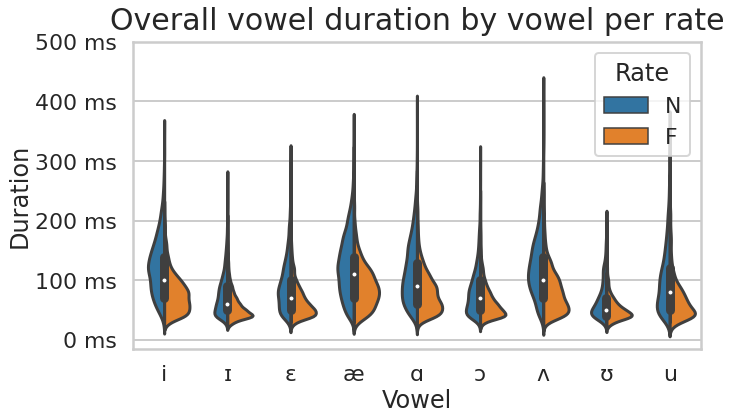

In [16]:
# Overall vowel duration (checking only mid-point)
which_time = 0.5
# with plt.style.context(['science', 'ieee', 'no-latex']):
with sns.plotting_context('paper'):
    fig, ax = duration_by_condition_boxplot(
        DN[DN.TimeAt == which_time],
        duration_col="Duration",
        hue="Rate", hue_order=['N','F'],
        condition_col="Vowel",
        condition_list=vowel_list,
        vowel2ipa=vowel2ipa,
    )
    ax.set_title("Overall vowel duration by vowel per rate", fontsize=30, y=1.02);
fig.tight_layout()

In [17]:
# Get duration stats
d = DN[DN.TimeAt == which_time].reset_index(drop=True).copy()
d = d[['Speaker','Rate','Vowel','Duration']]
d.groupby(['Speaker','Rate','Vowel']).agg(['mean','std']).reset_index()

Speaker Rate Vowel  Duration          
                            mean       std
0       F01    F   AA1  0.074833  0.027988
1       F01    F   AE1  0.085718  0.027592
2       F01    F   AH1  0.060700  0.021994
3       F01    F   AO1  0.075586  0.028264
4       F01    F   EH1  0.064296  0.024108
..      ...  ...   ...       ...       ...
139     M04    N   EH1  0.086937  0.046241
140     M04    N   IH1  0.075792  0.041131
141     M04    N   IY1  0.130512  0.052863
142     M04    N   UH1  0.078028  0.039682
143     M04    N   UW1  0.112218  0.058209

[144 rows x 5 columns]

In [18]:
# Plot duration by Vowel by Speaker
if save_again:
    condition_col = 'Vowel'
    duration_col = 'Duration'
    hue = 'Rate'
    which_time = 0.5
    
    for spkr in tqdm(spkr_list, total=len(spkr_list)):
        d = DN.loc[(DN.Speaker==spkr)&(DN.TimeAt==which_time)]
        fig, ax = duration_by_condition_boxplot(d, 
                                                duration_col=duration_col, hue=hue, hue_order=['N','F'],
                                                condition_col=condition_col, condition_list=vowel_list,
                                                vowel2ipa=vowel2ipa)
        plt.suptitle(f'Vowel duration by {condition_col} ({spkr})', fontsize=25);
        fig.savefig(os.path.join(plot_dir, spkr, f'{spkr}_duration.png'))
        plt.close()
    del d, fig
    print('Plots were saved')
else:
    print('Skipping...')

100%|██████████| 8/8 [00:01<00:00,  5.67it/s]

Plots were saved


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

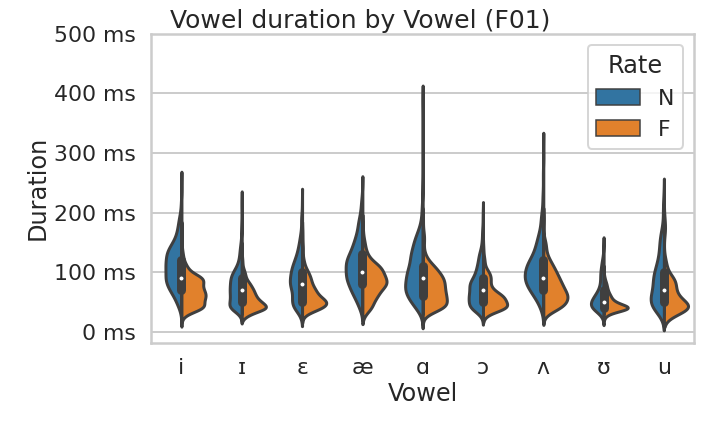

In [19]:
# Check duration plots
def func(which_spkr):
    return Image(filename=os.path.join(plot_dir, which_spkr, f'{which_spkr}_duration.png'), width=500)

interact(func, which_spkr=spkr_list);
func('F01')

### Check the contexts
- This should be re-calculated after outlier removal!

In [20]:
# Remove nasal coda context ('N, NG, M')
DN = DN.loc[(~DN.PostVowel.isin(["N", "NG", "M"]))].reset_index(drop=True)
print(DN.shape)  
# 2021-01-11: (231790, 31)
# 2021-01-19: (227050, 31)

(227125, 32)


In [21]:
# Remove rhotic coda context (delete 'r')
DN = DN.loc[(DN.PostVowel != "R")].reset_index(drop=True)
print(DN.shape)
# 2021-01-11: (231790, 31)
# 2021-01-19: (227050, 31)

(227125, 32)


In [22]:
# Remove rhotic and /w/ onset context
DN = DN.loc[(~DN.PreVowel.isin(['R', 'W']))].reset_index(drop=True)
print(DN.shape) 
# 2021-01-11: (193745, 31)
# 2021-01-19: (227050, 31)

(190055, 32)


In [23]:
# Exclude where word is 'sp'
DN = DN.loc[DN.Word != 'sp'].reset_index(drop=True)
print('After removing sp', DN.shape)
# 2021-01-11: (193745, 31)
# 2021-01-19: (189990, 31)

After removing sp (190055, 32)


In [24]:
# Check onset contexts and their counts
print("[h] initial:", (DN.PreVowel == "HH").sum())
print("[p] initial:", (DN.PreVowel == "P").sum())
print("[b] initial:", (DN.PreVowel == "B").sum())
print("[f] initial:", (DN.PreVowel == "F").sum())
print("[v] initial:", (DN.PreVowel == "V").sum())
print("[t] initial:", (DN.PreVowel == "T").sum())
print("[d] initial:", (DN.PreVowel.isin(["D","DH"]).sum()))
print("[s] initial:", (DN.PreVowel == "S").sum())
print("[sh] initial:", (DN.PreVowel == "SH").sum())
print("[k] initial:", (DN.PreVowel == "K").sum())
print("[g] initial:", (DN.PreVowel == "G").sum())
# --- 2021-01-11
# [h] initial: 12790
# [p] initial: 12065
# [b] initial: 11720
# [f] initial: 10850
# [v] initial: 1855
# [t] initial: 20370
# [d] initial: 21435
# [s] initial: 12920
# [sh] initial: 5455
# [k] initial: 13180
# [g] initial: 3835

# --- 2021-01-19
# [h] initial: 12515
# [p] initial: 11750
# [b] initial: 11515
# [f] initial: 10585
# [v] initial: 1840
# [t] initial: 19835
# [d] initial: 21205
# [s] initial: 12560
# [sh] initial: 5285
# [k] initial: 12825
# [g] initial: 3805

# --- 2021-01-27
# [h] initial: 12525
# [p] initial: 11755
# [b] initial: 11530
# [f] initial: 10585
# [v] initial: 1840
# [t] initial: 19840
# [d] initial: 21210
# [s] initial: 12560
# [sh] initial: 5290
# [k] initial: 12825
# [g] initial: 3805

[h] initial: 12525
[p] initial: 11755
[b] initial: 11530
[f] initial: 10585
[v] initial: 1840
[t] initial: 19840
[d] initial: 21210
[s] initial: 12560
[sh] initial: 5290
[k] initial: 12825
[g] initial: 3805


In [25]:
# Check data shape by rate per speaker
for spkr in spkr_list:
    print(spkr, DN.loc[DN.Speaker==spkr].shape)
    print('   ', 'N:', DN.loc[(DN.Speaker==spkr)&(DN.Rate=='N')].shape, 'F:', DN.loc[(DN.Speaker==spkr)&(DN.Rate=='F')].shape)

F01 (27120, 32)
    N: (17695, 32) F: (9425, 32)
F02 (23465, 32)
    N: (14180, 32) F: (9285, 32)
F03 (24000, 32)
    N: (14110, 32) F: (9890, 32)
F04 (25075, 32)
    N: (15025, 32) F: (10050, 32)
M01 (22145, 32)
    N: (13745, 32) F: (8400, 32)
M02 (21210, 32)
    N: (13055, 32) F: (8155, 32)
M03 (23865, 32)
    N: (14680, 32) F: (9185, 32)
M04 (23175, 32)
    N: (13705, 32) F: (9470, 32)


### Check articulatory data

In [26]:
def func_ca1(which_spkr, which_rate, which_vowel, which_time):
    d = DN.loc[(DN.Speaker==which_spkr)&(DN.Rate==which_rate)&(DN.Vowel==which_vowel)&(DN.TimeAt==which_time), artic_col]

    fig, ax = plt.subplots(1, figsize=(6,5), facecolor='white')

    # Original data
    plot_palpha(ax, pal_all[which_spkr], pha=None);
    plot_artic_df(ax, d, 
                  tongue_x=['TRx','TBx','TTx'], 
                  tongue_y=['TRz','TBz','TTz'], 
                  jaw_x=['JAWx'], jaw_y=['JAWz'], 
                  lip_x=['ULx','LLx'], lip_y=['ULz','LLz'], 
                  tongue_spline=True, 
                  xlim=(-70,40), ylim=(-50,30), 
                  xtickspacing=20, ytickspacing=20,
                  xlabel='Horizontal (back<->front)', ylabel='Vertical (low<->high)',
                  sns_theme='whitegrid', sns_context='poster')
    ax.set_title('Original', fontsize=25)

interact(func_ca1, which_spkr=spkr_list, which_rate=rate_list, which_vowel=vowel_list, which_time=time_list)

interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

<function __main__.func_ca1(which_spkr, which_rate, which_vowel, which_time)>

<h3 style="background-color: blue"> Acoustic data processing </h3>

#### Normalization prep
- Center & Rescale based on the vowel mid-point at normal rate

In [27]:
# Get vowel targets (medians) based on the Normal rate
VT = (DN[['Speaker','Vowel','TimeAt']+acous_col+artic_col]
      .loc[DN.Vowel.isin(vowel_list)]
      .groupby(['Speaker','Vowel','TimeAt'])
      .median().reset_index())
if save_again:
    VT.to_csv(os.path.join(save_dir, vowel_target_file), index=False)
    print('saved')
else:
    print('not saving')
print('Vowel median targets table size:', VT.shape)
VT.head(10)

saved
Vowel median targets table size: (360, 18)


,Speaker,Vowel,TimeAt,F1_mel,F2_mel,F3_mel,TRx,TRz,TBx,TBz,TTx,TTz,JAWx,JAWz,ULx,ULz,LLx,LLz
0,F01,AA1,0.00,721.446294,1246.117767,1786.395318,-54.791332,-10.360952,-40.766026,-6.600409,-23.165455,-10.521481,-6.770155,-28.775322,9.076078,4.074538,3.884725,-27.368029
1,F01,AA1,0.25,767.451983,1197.643196,1739.095737,-55.806007,-10.848241,-41.888344,-7.160785,-24.241262,-13.120911,-7.492266,-30.353844,9.115908,3.880620,3.222335,-29.142384
2,F01,AA1,0.50,780.202900,1197.157392,1703.997345,-56.002995,-11.390790,-42.587395,-7.020056,-24.554470,-12.789339,-7.681463,-30.449701,8.915159,3.733081,3.014798,-29.247967
3,F01,AA1,0.75,764.289976,1213.749084,1734.700469,-55.386528,-11.191369,-42.368973,-5.680758,-23.934340,-8.998278,-7.313000,-29.487858,8.661475,3.673651,3.250842,-27.618141
4,F01,AA1,1.00,725.715481,1236.548473,1747.023253,-54.219887,-10.720758,-41.743504,-4.416835,-23.460876,-6.021664,-6.776461,-27.817003,8.576008,3.786060,3.726748,-25.571333
5,F01,AE1,0.00,727.754263,1454.532879,1842.886949,-49.509243,-7.446817,-34.506474,-4.403622,-17.502764,-14.642928,-6.679670,-29.336416,6.667424,4.659668,2.074585,-28.693830
6,F01,AE1,0.25,800.671153,1447.735952,1824.208201,-50.179234,-7.628213,-35.188076,-5.073350,-18.298948,-16.610739,-7.470892,-30.923233,6.536406,4.537700,0.980674,-30.767393
7,F01,AE1,0.50,816.853486,1436.549085,1812.121037,-50.630344,-7.818588,-35.923400,-4.921708,-18.760960,-15.901377,-7.345469,-30.121174,6.474283,4.433979,1.045319,-29.774858
8,F01,AE1,0.75,782.535808,1433.450364,1832.946788,-50.770412,-7.944861,-36.493763,-4.177666,-18.654896,-12.339047,-6.626700,-28.037899,6.784428,4.513108,2.086935,-26.977053
9,F01,AE1,1.00,732.072108,1435.386666,1837.674290,-50.192930,-8.030566,-36.485660,-3.342102,-18.763710,-7.628329,-5.759757,-25.765373,7.285101,4.722023,3.440494,-23.746515


In [28]:
# Get vowel grandmean based on 4 corner vowels per speaker across rate
GM = VT.loc[VT.Vowel.isin(corner_vowels)].groupby(['Speaker']).mean().reset_index()
if save_again:
    GM.to_csv(os.path.join(save_dir, grand_mean_file), index=False)
    print('saved')
else:
    print('not saving')
print('Grandmean table size:', GM.shape)
GM

saved
Grandmean table size: (8, 17)


,Speaker,TimeAt,F1_mel,F2_mel,F3_mel,TRx,TRz,TBx,TBz,TTx,TTz,JAWx,JAWz,ULx,ULz,LLx,LLz
0,F01,0.5,612.497019,1440.216942,1812.730647,-50.812052,-5.102797,-36.405553,-1.315424,-18.666622,-10.491925,-5.610907,-26.300203,8.229517,4.263319,4.124076,-25.382307
1,F02,0.5,653.293787,1443.096033,1804.783738,-50.789113,0.188205,-36.077761,-0.210469,-17.878596,-7.868699,-5.389779,-21.935920,8.260942,5.249027,6.640900,-28.486943
2,F03,0.5,711.580686,1478.225576,1866.808388,-44.365314,-4.410876,-27.867387,-3.194879,-14.806128,-10.804709,1.408028,-22.294064,10.079717,0.369195,11.249769,-25.980379
3,F04,0.5,663.432611,1420.944734,1852.652356,-44.749410,1.527808,-27.637371,-4.631450,-16.555151,-11.694015,-2.630832,-20.174388,8.706033,6.141346,6.212125,-29.117447
4,M01,0.5,600.830185,1362.920360,1711.638394,-39.857924,-5.266310,-24.604246,-10.043047,-15.551770,-13.253429,-0.528088,-23.731837,12.172886,1.651007,11.682898,-27.906357
5,M02,0.5,562.879009,1287.014636,1763.462393,-58.588757,-6.226837,-35.980183,-1.253426,-13.512033,-13.660674,0.358192,-22.829426,11.067648,5.916220,13.709684,-27.592615
6,M03,0.5,614.631587,1387.842385,1713.894809,-50.135748,1.380126,-32.887440,0.030531,-15.999365,-10.105438,-2.079831,-20.783179,11.672177,-1.849262,5.831491,-28.590544
7,M04,0.5,598.759202,1347.681206,1680.619706,-42.160547,-3.063499,-30.658807,-3.907169,-18.831213,-9.135981,-2.911996,-21.959011,11.387004,0.818816,8.105274,-25.648486


#### Normalization & Parameter extraction

In [29]:
# Center & Rescale data based on Normal rate
# - Get center-rescale param from acous (aross rates and time)
# - Get zscore param from artic (based on both rates)
DN['AcousVar'] = 0
DN['ArticVar'] = 0
DN['RescaleFactorAcous'] = 0
DN['RescaleFactorArtic'] = 0
grand_mean_col = [re.sub('_mel', '_grandmean', ac) for ac in acous_col]
DN[grand_mean_col] = 0
DN[acous_col_norm] = 0
DN[artic_col_norm] = 0
DN[acous_col_norm] = DN[acous_col_norm].astype(float)
DN[artic_col_norm] = DN[artic_col_norm].astype(float)

Z = {}
for spkr in tqdm(spkr_list, total=len(spkr_list)):
    # grandmean is already calculated based on both rates
    condition = (DN.Speaker==spkr)
    acous = DN.loc[condition, acous_col].values
    artic = DN.loc[condition, artic_col].values
    vowel_targets = VT[(VT.Speaker==spkr)].reset_index()
    grandmean_ac = GM.loc[GM.Speaker==spkr, acous_col].values
    grandmean_ar = GM.loc[GM.Speaker==spkr, artic_col].values

    # Get rescale unit (mean of vector length)
    lengths_ac = np.sqrt(np.sum((acous - grandmean_ac)**2, axis=1))
    rescale_factor_ac = lengths_ac.mean()
    lengths_ar = np.sqrt(np.sum((artic - grandmean_ar)**2, axis=1))
    rescale_factor_ar = lengths_ar.mean()

    # Center & Rescale
    acous = (acous - grandmean_ac) / rescale_factor_ac
    artic = (artic - grandmean_ar) / rescale_factor_ar
    vowel_targets[acous_col] = (vowel_targets[acous_col].values - grandmean_ac) / rescale_factor_ac # update
    vowel_targets[artic_col] = (vowel_targets[artic_col].values - grandmean_ar) / rescale_factor_ar # update
    
    # Calculate variability from the each vowel target in the normalized space
    #lengths = np.sqrt(np.sum(acous**2, axis=1))
    #lengths_artic = np.sqrt(np.sum(artic**2, axis=1))

    # Update
    DN.loc[condition, acous_col_norm] = acous
    DN.loc[condition, ['RescaleFactorAcous']] = rescale_factor_ac
    DN.loc[condition, grand_mean_col] = grandmean_ac
    DN.loc[condition, artic_col_norm] = artic
    DN.loc[condition, ['RescaleFactorArtic']] = rescale_factor_ac
    #DN.loc[condition, ['AcousDist']] = lengths
    #DN.loc[condition, ['ArticDist']] = lengths_artic
    
    # Iterate over vowels for AcousDist and ArticDist
    for which_vowel in vowel_list:
        for which_time in time_list:
            # --- AcousDist
            m = vowel_targets.loc[(vowel_targets.Vowel==which_vowel)&(vowel_targets.TimeAt==which_time), acous_col].values
            #m = (m - grandmean_ac) / rescale_factor_ac
            d = DN.loc[condition&(DN.Vowel==which_vowel)&(DN.TimeAt==which_time), acous_col_norm].values
            dist = np.sqrt(np.sum((d - m)**2, axis=1))
            DN.loc[condition&(DN.Vowel==which_vowel)&(DN.TimeAt==which_time), 'AcousVar'] = dist

            # --- ArticDist
            m = vowel_targets.loc[(vowel_targets.Vowel==which_vowel)&(vowel_targets.TimeAt==which_time), artic_col].values
            #m = (m - grandmean_ar) / rescale_factor_ar
            d = DN.loc[condition&(DN.Vowel==which_vowel)&(DN.TimeAt==which_time), artic_col_norm].values
            dist = np.sqrt(np.sum((d - m)**2, axis=1))
            DN.loc[condition&(DN.Vowel==which_vowel)&(DN.TimeAt==which_time), 'ArticVar'] = dist
        
    # Update normalizing parameters
    Z.update({
        spkr: {
            # Acous
            'acous': {'mean': {acous_col[j]: grandmean_ac[0,j] for j in range(len(acous_col))},
                      'std': {acous_col[j]: rescale_factor_ac for j in range(len(acous_col))}},
            # Artic -- specify N rate here
            'artic': {'mean': {ar:mu for ar, mu in zip(artic_col, grandmean_ar)}, 
                      'std':  {ac: rescale_factor_ar for ac in artic_col}}
        },
        '_info_': 'based on both rates. mean is the grandmean. std is the scaling factor. see whalen 2018'
    })

if save_again:
    with open(os.path.join(save_dir, 'zscore.pkl'), 'wb') as pckl:
        pickle.dump(Z, pckl)
    print('Saved')
else:
    print('Done')
print(DN.shape) # (193745, 51)

100%|██████████| 8/8 [00:11<00:00,  1.40s/it]

Saved
(190055, 54)


In [30]:
# Plot temporal AcousVar by speaker, vowel and rate (before outlier removal)
if save_again:
    sns.set_theme(context='paper')
    for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
        g = sns.catplot(x='Vowel', y='AcousVar', hue='TimeAt', col='Rate', 
                        col_order=['N','F'] , order=vowel_list,
                        data=DN.loc[DN.Speaker==which_spkr], kind='box', aspect=2)
        g.set(ylim=[-0.1, 7])
        plt.suptitle(f'{which_spkr}', fontsize=20, y=1.02)
        # Save
        plt.gcf().savefig(os.path.join(plot_dir, which_spkr, f'{which_spkr}_acousvar_before_outlier.png'), bbox_inches='tight')
        plt.close()
else:
    print('Skipping...')

100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

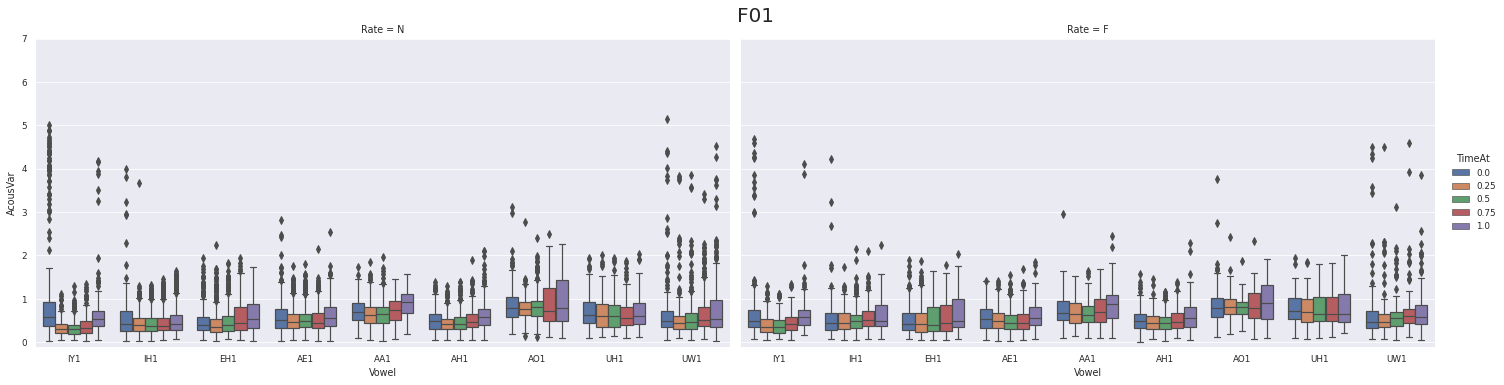

In [31]:
# Check duration plots
def func(which_spkr):
    return Image(filename=os.path.join(plot_dir, which_spkr, f'{which_spkr}_acousvar_before_outlier.png'), width=1000)

interact(func, which_spkr=spkr_list);
func('F01')

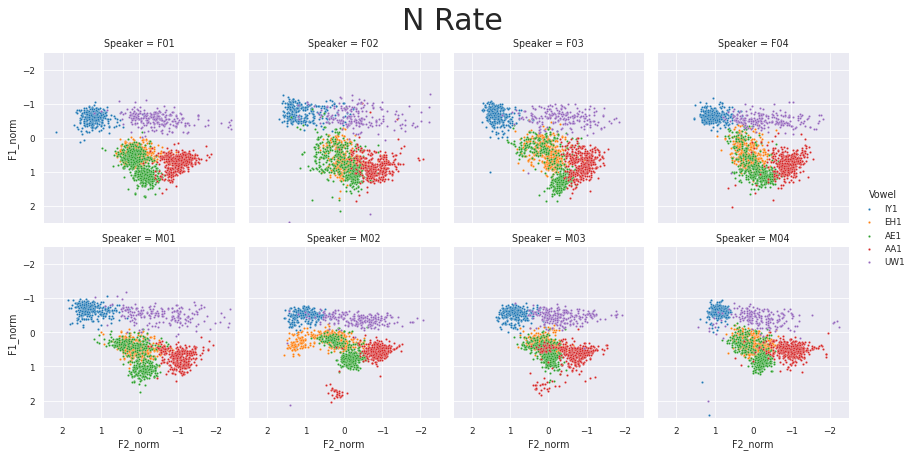

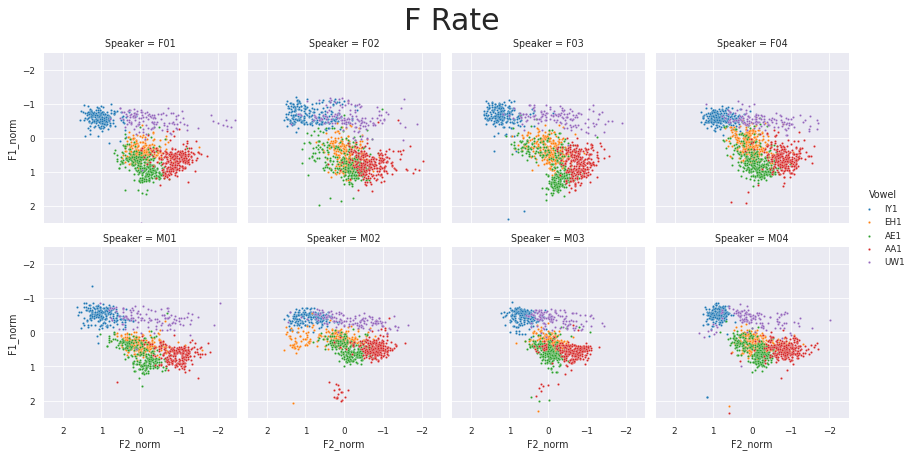

In [32]:
# Check normalized formants (before outlier removal)
time_point = 0.5
custom_vowels = ['IY1','EH1','AE1','AA1','UW1']
palette = sns.color_palette("tab10", len(custom_vowels))
xm, ym = 2.5, 2.5

for which_rate in ['N','F']:
    d = DN.loc[(DN.Rate==which_rate)&(DN.Vowel.isin(custom_vowels))&(DN.TimeAt==time_point)].reset_index(drop=True)
    g = sns.FacetGrid(data=d, col='Speaker', col_wrap=4, height=3, hue='Vowel', hue_order=custom_vowels, palette=palette)
    g.map(sns.scatterplot, 'F2_norm', 'F1_norm', s=5)
    g.add_legend()

    plt.gca().set_xlim([xm, -xm]);
    plt.gca().set_ylim([ym, -ym]);
    plt.suptitle(f'{which_rate.upper()} Rate', y=1.05, fontsize=30);
    plt.gcf().set_facecolor('white')
    plt.gcf().savefig(
        os.path.join(plot_dir, f'{which_rate}_acousvar_before_outlier_over_time.png'), 
        bbox_inches='tight')

#### Formant outlier removal

🧐 Before outlier removal

In [33]:
# Define helper functions
def _plot_dur_vowels(df, which_spkr, which_time, custom_vowels):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), facecolor='white')
    ax1 = plot_duration(ax1, df, which_spkr, custom_vowels, vowel2ipa)
    ax2 = plot_F1F2_df(ax2, df.loc[(df.Speaker==which_spkr)&(df.Rate=='N')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa)
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker==which_spkr)&(df.Rate=='F')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa)
    # Titles
    ax1.set_title('Duration', fontsize=25);
    ax2.set_title('Normal rate', fontsize=25);
    ax3.set_title('Fast rate', fontsize=25);
    fig.suptitle(f'Speaker: {which_spkr}', y=0.9);
    fig.tight_layout()
    return fig, [ax1, ax2, ax3]

def _plot_dur_vowel_spaces(df, which_spkr, which_time, custom_vowels, 
                           center_stat='median',
                           show_title=True, 
                           ax2_title='Vowel space (ellipses)',
                           ax3_title='Vowel space (quadrilateral)'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), facecolor='white')
    # --- Duration plot
    ax1 = plot_duration(ax1, df.loc[df.Speaker==which_spkr], which_spkr, custom_vowels, vowel2ipa)
    # --- Ellipse plot
    ax2 = plot_F1F2_df(ax2, df.loc[(df.Speaker==which_spkr)&(df.Rate=='N')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa, 
                       center_only=False,
                       ellipse_only=True,
                       ellipse_linestyle='-',
                      )
    ax2 = plot_F1F2_df(ax2, df.loc[(df.Speaker==which_spkr)&(df.Rate=='F')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', show_label=False, 
                       center_only=False,
                       ellipse_only=True,
                       ellipse_linestyle='--',
                      )
    # Prettify
    l1, = ax2.plot([], [], 'k-', linewidth=2)
    l2, = ax2.plot([], [], 'k--', linewidth=2)
    ax2.legend([l1, l2], ['N','F'], fontsize=10)

    # --- Line plot
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker==which_spkr)&(df.Rate=='N')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa, 
                       center_only=center_stat,
                       connected_linestyle='-'
                      )
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker==which_spkr)&(df.Rate=='F')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', show_label=False, 
                       center_only=center_stat,
                       connected_linestyle='--'
                      )
    # Prettify
    l1, = ax3.plot([], [], 'k-', linewidth=2)
    l2, = ax3.plot([], [], 'k--', linewidth=2)
    ax3.legend([l1, l2], ['N','F'], fontsize=10)

    # Titles
    ax1.set_title('Duration', fontsize=25, y=1.02);
    ax2.set_title(ax2_title, fontsize=25, y=1.02);
    ax3.set_title(ax3_title, fontsize=25, y=1.02);

    if show_title:
        fig.suptitle(f'Speaker: {which_spkr}', y=0.9);
    fig.tight_layout()
    return fig, [ax1, ax2, ax3]

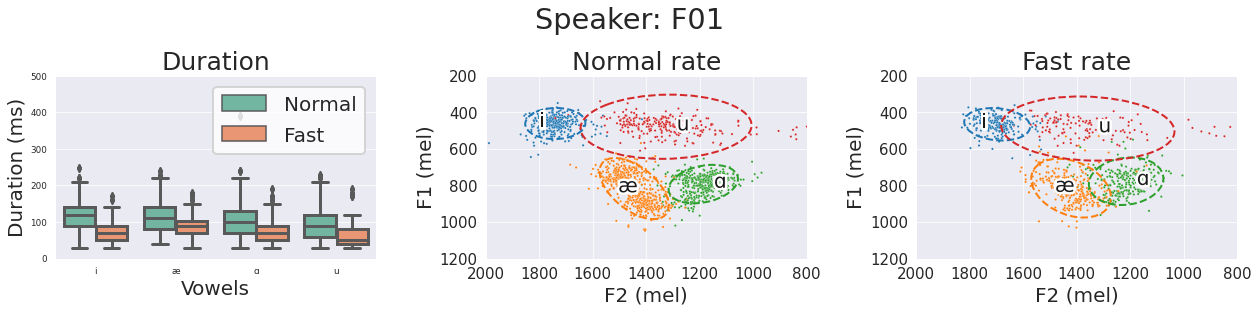

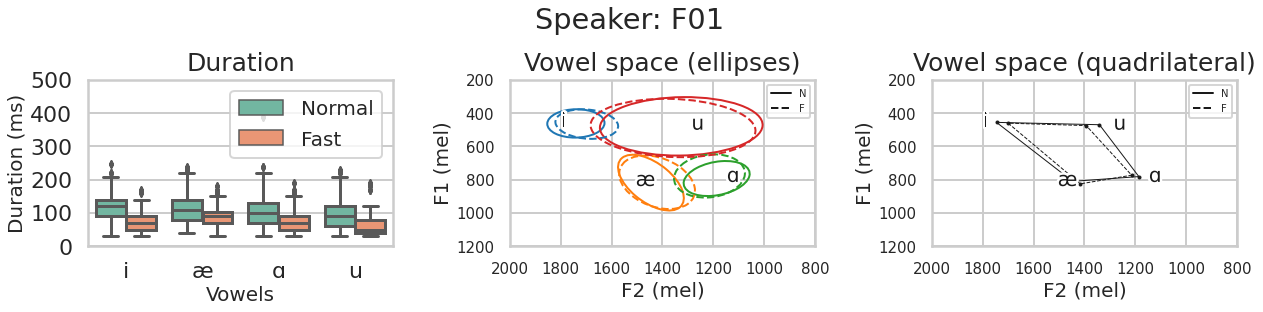

In [34]:
# Plot overall duration and formant patterns for checking
which_spkr = 'F01'
which_time = 0.5
custom_vowels = corner_vowels

fig, arr = _plot_dur_vowels(DN, which_spkr, which_time, custom_vowels)
fig, arr = _plot_dur_vowel_spaces(DN, which_spkr, which_time, custom_vowels)

In [35]:
if save_again:
    for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
        # Plot
        with sns.plotting_context(context='poster'):
            sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
            fig, arr = _plot_dur_vowels(DN, which_spkr, which_time, custom_vowels)
        
        # Save
        fig.savefig(os.path.join(plot_dir, which_spkr, f'{which_spkr}_before_outlier.png'), bbox_inches="tight")
        plt.close()
    del fig, arr
    print('Done')
else:
    print('Skipped')

100%|██████████| 8/8 [00:04<00:00,  1.75it/s]

Done


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

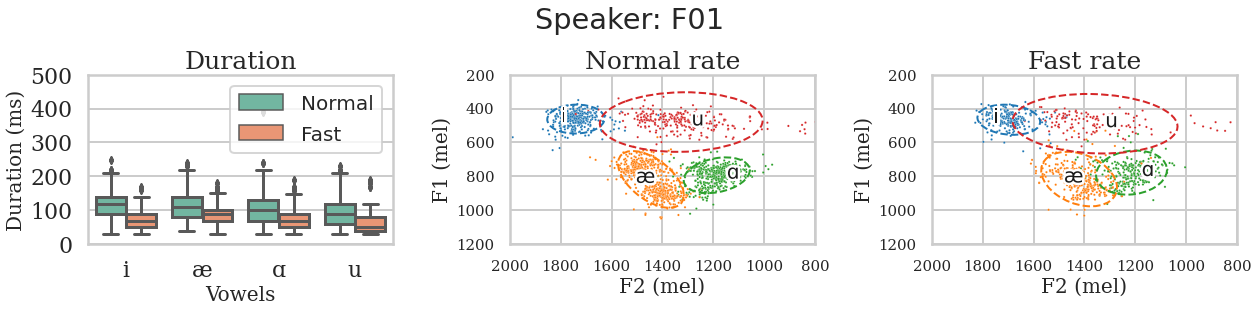

In [36]:
# Check duration plots
def func(which_spkr):
    return Image(filename=os.path.join(plot_dir, which_spkr, f'{which_spkr}_before_outlier.png'), width=1000)

interact(func, which_spkr=spkr_list);
func('F01')

👹 After outlier removal

- Two methods: IQR or IsolationTree
- Outlier removal is based on the vowel acoustic midpoints

In [37]:
# Select which method to use to remove outliers
removal_method = "IsolationTree"  # IQR or IsolationTree

if removal_method == 'IQR':
    lower_bound = 0.25
    upper_bound = 0.75
    
elif removal_method == 'IsolationTree':
    #outliers_fraction = 0.1
    outliers_fraction = 'auto'

print('Method chosen:', removal_method)

Method chosen: IsolationTree


In [38]:
def _remove_acous_outlier_single_variable(df, which_spkr, which_vowel, which_rate, acous_column, 
                                         spkr_col='Speaker', vowel_col='Vowel', rate_col='Rate', time_col='TimeAt',
                                         ref_time=0.5, id_col='Token',
                                         lower_bound=0.25, upper_bound=0.75):
    '''Remove acoustic outlier based on a single variable (e.g., AcousVar, F1 etc.)
    
    df: the entire dataframe (without conditional filtering)
    acous_column: eg. 'F1', 'AcousVar' (NOT this: ['F1_mel', 'F2_mel'])
    ref_time: reference time point
    id_col: unique token id column
    '''
    d = df.loc[(
        (df[spkr_col]==which_spkr)
        &(df[vowel_col]==which_vowel)
        &(df[rate_col]==which_rate)
        &(df[time_col]==ref_time)
    )]
    
    lb, ub = iqr_bounds(d, acous_column, lb=lower_bound, ub=upper_bound)
    outliers = d.loc[(d[acous_column]<lb) | (d[acous_column]>ub)]
    unique_tokens = outliers[id_col].unique().tolist()
    df = df.loc[~(df[id_col].isin(unique_tokens))]
    df.reset_index(drop=True, inplace=True)
    return df, unique_tokens

In [39]:
# This part is data-specific
DF = DN.copy() 

acous_column = 'AcousVar'
total_tokens = DF.Token.unique()[-1]
which_time = 0.5 # mid point
removed_tokens = 0

########## REMOVE NEXT TIME #########
# save_again = True
#####################################

stat = []
if save_again:
    # Iterate over speakers
    for i in tqdm(range(len(spkr_list))):
        spkr = spkr_list[i]
        # Iterate over vowels
        for vowel in vowel_list:
            # Iterate over speech rate
            for rate in ['N','F']:
                ########################################
                if removal_method == 'IQR':
                    # ----- IQR method
                    DF, unique_tokens = _remove_acous_outlier_single_variable(
                        DF, spkr, vowel, rate, acous_column, 
                        ref_time=0.5, id_col='Token',
                        lower_bound=0.25, upper_bound=0.75)
                    removed_tokens += len(unique_tokens)

                ########################################
                elif removal_method == 'IsolationTree':
                    # Acous
                    d = DF.loc[(DF.Speaker == spkr) & (DF.Vowel == vowel) & (DF.Rate == rate) & (DF.TimeAt == which_time)]
                    X = d[acous_col].values
                    clf = IsolationForest(n_estimators=100, warm_start=True, contamination=outliers_fraction, random_state=rand_seed)
                    clf.fit(X)
                    Y_acous = clf.predict(X)  # predict
                    XX = d.iloc[Y_acous == 1]
                    acous_out = sum(Y_acous == -1)/len(Y_acous)
                    # Update
                    unique_tokens = d.iloc[Y_acous == -1]['Token'].unique()
                    DF.drop(DF.loc[DF.Token.isin(unique_tokens)].index, inplace=True)
                    DF.reset_index(drop=True)
                    removed_tokens += len(unique_tokens)

                    # Artic
                    d = DF.loc[(DF.Speaker == spkr) & (DF.Vowel == vowel) & (DF.Rate == rate) & (DF.TimeAt == which_time)]
                    X = d[artic_col].values
                    clf2 = IsolationForest(n_estimators=100, warm_start=True, contamination=outliers_fraction, random_state=rand_seed)
                    clf2.fit(X)
                    Y_artic = clf2.predict(X)  # predict
                    dd = d.iloc[Y_artic == 1]  # filtered data
                    artic_out = sum(Y_artic == -1)/len(Y_artic)
                    # Update
                    unique_tokens = d.iloc[Y_artic == -1]['Token'].unique()
                    DF.drop(DF.loc[DF.Token.isin(unique_tokens)].index, inplace=True)
                    DF.reset_index(drop=True)
                    removed_tokens += len(unique_tokens)

                    #stat.append([spkr, vowel, cond, acous_out, (1 - acous_out)*artic_out, acous_out + (1 - acous_out)*artic_out])

    # --- Based on DN
    print(f'Original:{DN.shape} ==> Cleaned:{DF.shape}')
    print(f'Reduced about {(len(DN)-len(DF))/len(DN)*100:.2f} %')
    print(f'Tokens reduced {removed_tokens} ({removed_tokens/total_tokens*100:.2f} %) from total of {total_tokens}')
else:
    # If not save_again
    # just load the already cleaned data file
    DF = pd.read_csv(new_file)
    print('Loaded from saved data')

##### 2021-01-11
# --- IsolationTree: outliers fraction='auto'
# Original:(193745, 51) ==> Cleaned:(143100, 51)
# Reduced about 26.14 %
# Tokens reduced 10129 (19.04 %) from total of 53199    

# --- IsolationTree: outliers fraction=0.1
# Original:(193745, 51) ==> Cleaned:(156460, 51)
# Reduced about 19.24 %
# Tokens reduced 7457 (14.02 %) from total of 53199

# --- IQR
# Original:(193745, 51) ==> Cleaned:(185630, 51)
# Reduced about 4.19 %
# Tokens reduced 1623 (3.05 %) from total of 53199

##### 2021-01-19
# --- IsolationTree: outliers fraction='auto'
# Original:(189990, 51) ==> Cleaned:(139520, 51)
# Reduced about 26.56 %
# Tokens reduced 10094 (19.39 %) from total of 52061

##### 2021-01-27 (F1, F2)
# Original:(190055, 51) ==> Cleaned:(138575, 51)
# Reduced about 27.09 %
# Tokens reduced 10296 (19.77 %) from total of 52079

##### 2021-04-27 (F1, F2, F3)
# Original:(190055, 54) ==> Cleaned:(140305, 54)
# Reduced about 26.18 %
# Tokens reduced 9950 (19.11 %) from total of 52079

100%|██████████| 8/8 [00:44<00:00,  5.62s/it]

Original:(190055, 54) ==> Cleaned:(140305, 54)
Reduced about 26.18 %
Tokens reduced 9950 (19.11 %) from total of 52079


In [40]:
# Check if each time point have the same data points
DF.TimeAt.value_counts()
# 0.00    27904
# 0.75    27904
# 0.25    27904
# 1.00    27904
# 0.50    27904

### 2021-04-26 (F1, F2)
# 0.00    27715
# 0.75    27715
# 0.25    27715
# 1.00    27715
# 0.50    27715

### 2021-04-27 (F1, F2, F3)
# 0.00    28061
# 0.75    28061
# 0.25    28061
# 1.00    28061
# 0.50    28061

0.00    28061
0.75    28061
0.25    28061
1.00    28061
0.50    28061
Name: TimeAt, dtype: int64

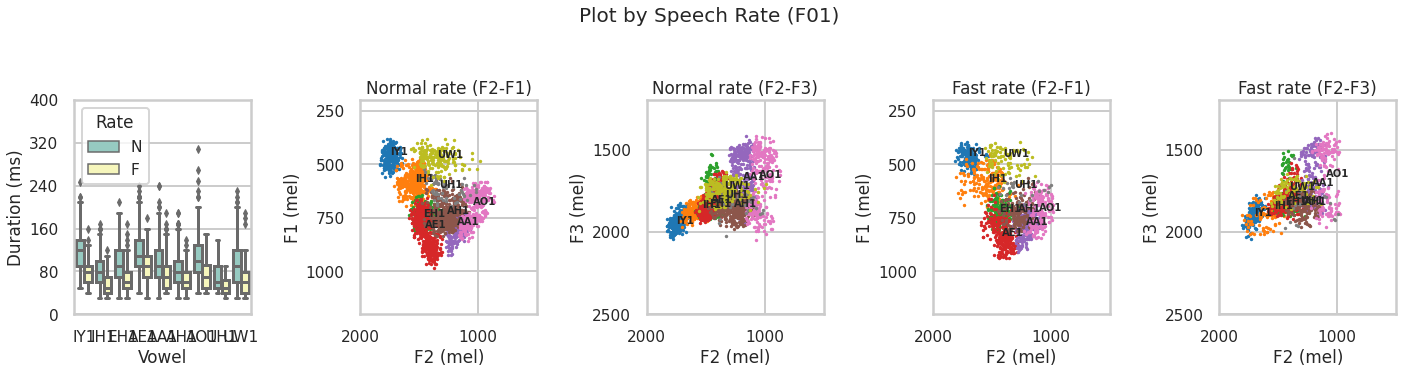

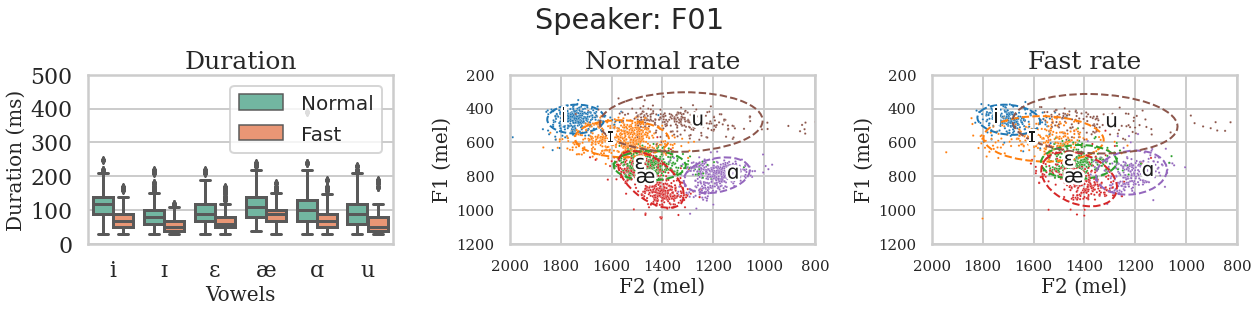

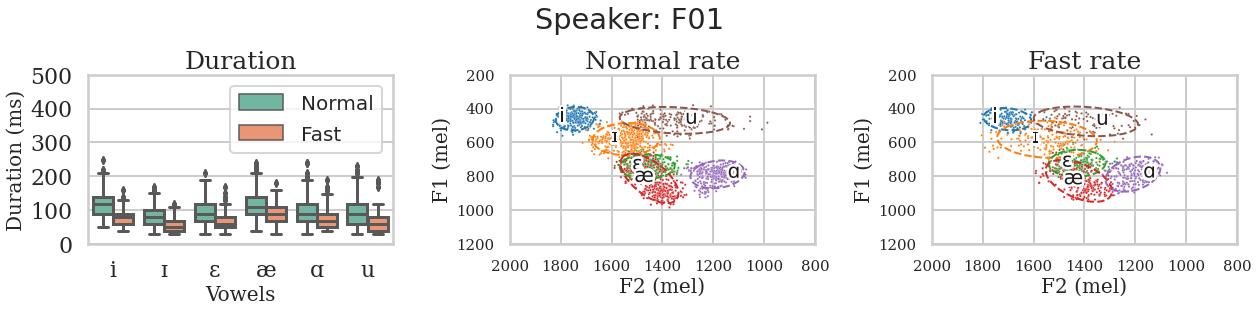

In [50]:
# Check the result of the ourlier removal quickly
# Quick check (for myself)
which_spkr = 'F01'
which_time = 0.5
# custom_vowels = vowel_list
custom_vowels = ['IY1', 'IH1', 'EH1', 'AE1', 'AA1', 'UW1']
# custom_vowels = ['IY1', 'AE1', 'AA1', 'UW1']

if len(acous_col) == 3:
    with sns.plotting_context(context='poster', font_scale=0.7):
        fig, arr = plt.subplots(1, 5, figsize=(20, 5), facecolor='white')
        _plot_dur_formants_by_rate(DF.loc[(DF.Speaker == which_spkr) & (DF.TimeAt == which_time)], arr, vowel_list,
                                   x='Vowel', y='Duration', hue='Rate',
                                   title=f'Plot by Speech Rate ({which_spkr})',
                                   use_mel=use_mel)
        fig.tight_layout()
        
# if len(acous_col) == 2:
# Before outlier removal
with sns.plotting_context(context='poster'):
    sns.set_style(
        "whitegrid", {'font.family': 'serif', 'font.serif': 'Times New Roman'})
    fig, arr = _plot_dur_vowels(DN, which_spkr, which_time, custom_vowels)

# After outlier removal
with sns.plotting_context(context='poster'):
    sns.set_style(
        "whitegrid", {'font.family': 'serif', 'font.serif': 'Times New Roman'})
    fig, arr = _plot_dur_vowels(DF, which_spkr, which_time, custom_vowels)

In [51]:
if save_again:
    which_time = 0.5
    custom_vowels = ['IY1', 'IH1', 'EH1', 'AE1', 'AA1', 'UW1']
    #custom_vowels = ['IY1', 'AE1', 'AA1', 'UW1']
    #custom_vowels = vowel_list
    
    for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
        # Plot
        # --- vowel space with point distribution
        with sns.plotting_context(context='poster'):
            sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
            fig, arr = _plot_dur_vowels(DF, which_spkr, which_time, custom_vowels)
            
        # Save
        fig.savefig(os.path.join(plot_dir, which_spkr, f'{which_spkr}_after_outlier.png'), bbox_inches="tight")
        plt.close()
        
        # --- vowel spaces as in ovoids and quadrilateral
        with sns.plotting_context(context='poster'):
            sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
            fig, arr = _plot_dur_vowel_spaces(DF, which_spkr, which_time, custom_vowels)
            
        # Save
        fig.savefig(os.path.join(plot_dir, which_spkr, f'{which_spkr}_after_outlier_ovoids.png'), bbox_inches="tight")
        plt.close()
    print('Done')
else:
    print('Skipping...')

100%|██████████| 8/8 [00:12<00:00,  1.51s/it]

Done


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

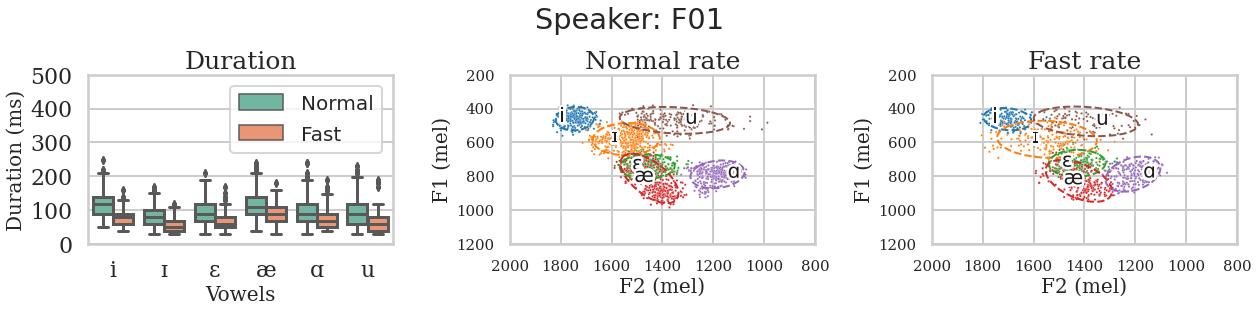

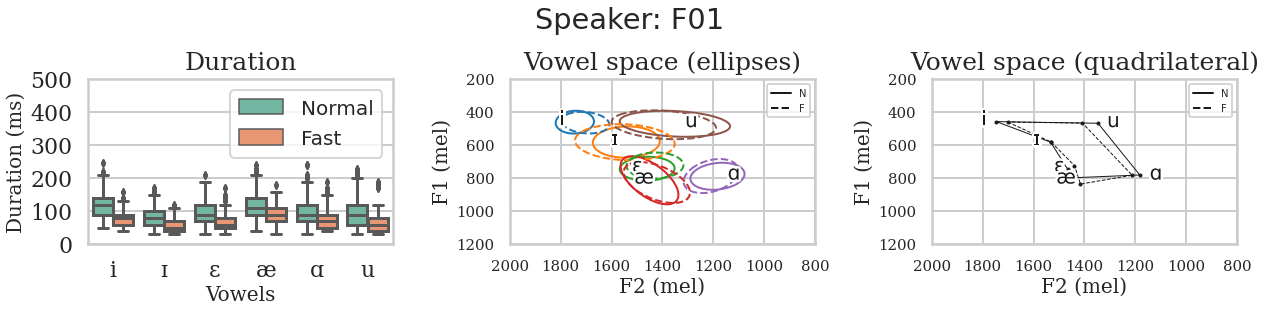

In [52]:
# Check duration plots
def func(which_spkr):
    file1 = os.path.join(plot_dir, which_spkr, f'{which_spkr}_after_outlier.png')
    file2 = os.path.join(plot_dir, which_spkr, f'{which_spkr}_after_outlier_ovoids.png')
    image1 = Image(filename=file1, width=1000)
    image2 = Image(filename=file2, width=1000)
    return display(image1, image2)

interact(func, which_spkr=spkr_list);
func('F01')

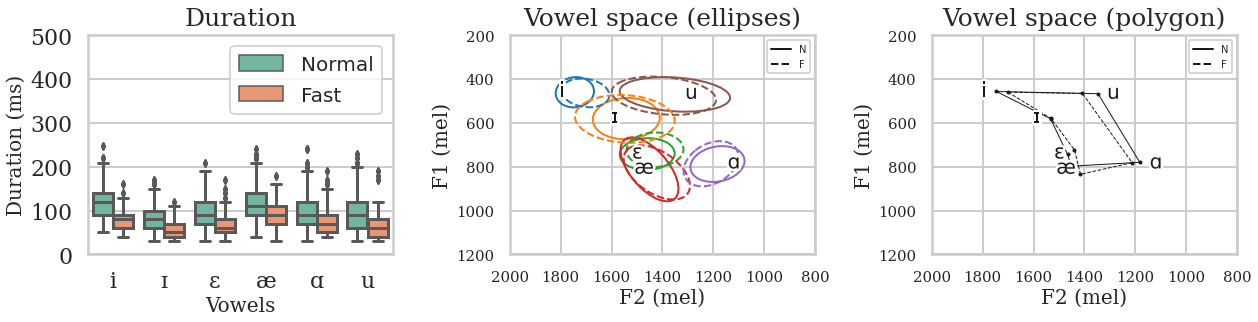

In [53]:
# Quick test on speaker, custom_vowels
which_spkr = 'F01'
which_time = 0.5
# custom_vowels = corner_vowels
custom_vowels = ['IY1', 'IH1', 'EH1', 'AE1', 'AA1', 'UW1']

with sns.plotting_context(context='poster'):
    sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
    fig, arr = _plot_dur_vowel_spaces(DF, which_spkr, which_time, custom_vowels, 
                                      show_title=False, 
                                      center_stat='median',
                                      ax2_title='Vowel space (ellipses)',
                                      ax3_title='Vowel space (polygon)',
                                      #ax3_title='Vowel space (quadrilateral)'
                                     )

<h3 style="background-color: blue">Articulatory data processing </h3>

### Check NaNs

In [54]:
num_nans = DF[artic_col].isna().sum().sum()
if num_nans > 0:
    raise Exception(f"There are {num_nans} NaNs! Check your sensor data")
else:
    print("No NaNs were found")

No NaNs were found


In [55]:
# Reset data
DF.reset_index(drop=True, inplace=True)
print(DF.shape)

(140305, 54)


### Check articulatory data
- Does the mid-sagittal plane make sense?
- Was the normalization process valid?

interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

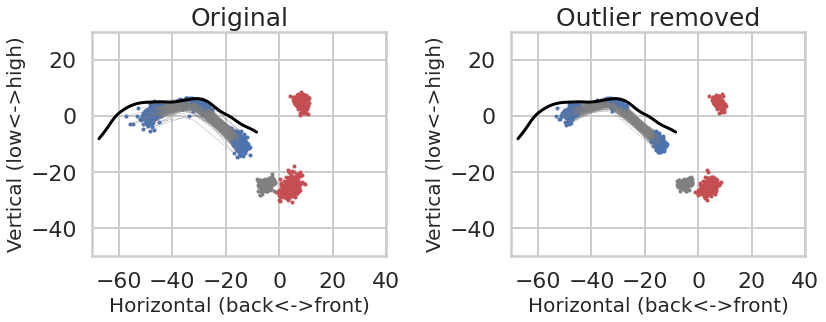

In [56]:
def func_ca(which_spkr, which_rate, which_vowel, which_time):
    scaler = Scaler(which_spkr, Z)
    d_old = DN.loc[(DN.Speaker==which_spkr)&(DN.Rate==which_rate)&(DN.Vowel==which_vowel)&(DN.TimeAt==which_time), artic_col]
    d_new = DF.loc[(DF.Speaker==which_spkr)&(DF.Rate==which_rate)&(DF.Vowel==which_vowel)&(DF.TimeAt==which_time), artic_col]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), facecolor='white')

    # --- Original data
    plot_palpha(ax1, pal_all[which_spkr], pha=None);
    plot_artic_df(ax1, d_old, 
                  tongue_x=['TRx','TBx','TTx'], 
                  tongue_y=['TRz','TBz','TTz'], 
                  jaw_x=['JAWx'], jaw_y=['JAWz'], 
                  lip_x=['ULx','LLx'], lip_y=['ULz','LLz'], 
                  tongue_spline=True, 
                  xlim=(-70,40), ylim=(-50,30), 
                  xtickspacing=20, ytickspacing=20,
                  xlabel='Horizontal (back<->front)', ylabel='Vertical (low<->high)',
                  sns_theme='whitegrid', sns_context='poster')
    ax1.set_title('Original', fontsize=25)
    
    # --- Outlier-removed data
    plot_palpha(ax2, pal_all[which_spkr], pha=None);
    plot_artic_df(ax2, d_new, 
                  tongue_x=['TRx','TBx','TTx'], 
                  tongue_y=['TRz','TBz','TTz'], 
                  jaw_x=['JAWx'], jaw_y=['JAWz'], 
                  lip_x=['ULx','LLx'], lip_y=['ULz','LLz'], 
                  tongue_spline=True, 
                  xlim=(-70,40), ylim=(-50,30), 
                  xtickspacing=20, ytickspacing=20,
                  xlabel='Horizontal (back<->front)', ylabel='Vertical (low<->high)',
                  sns_theme='whitegrid', sns_context='poster')
    ax2.set_title('Outlier removed', fontsize=25)

interact(func_ca, which_spkr=spkr_list, which_rate=rate_list, which_vowel=vowel_list, which_time=time_list)
func_ca('F01','N','IY1',0.5)

### Run PCA and save params
- PCA is based on the normal rate and data from acoustic-mid points

In [57]:
# Save
if save_again:
    which_rate = 'N'
    which_time = 0.5
    PC = {}
    for i in tqdm(range(len(spkr_list))):
        spkr = spkr_list[i]
        data = DF.loc[(DF.Speaker==spkr)&(DF.TimeAt==which_time)&(DF.Rate==which_rate), artic_col].values
        scaler = Scaler(spkr, Z)
        zdata = scaler.transform(data, 'artic')

        # Regular PCA
        pca = PCA(n_components=num_pca)
        pca.fit(zdata)
        PC.update({
            spkr: {
                'pca': pca,
                'components': pca.components_.tolist(),
                'explained_variance_ratio_': pca.explained_variance_ratio_.tolist(),
                'singular_values_': pca.singular_values_.tolist(),
                'info': f'regular pca, extracted {get_date()}'}})

    # Save
    with open(os.path.join(save_dir, pca_file), 'wb') as pckl:
        pickle.dump(PC, pckl)
    print(os.path.join(save_dir, pca_file), 'Saved')
else:
    # If parameters are saved before, just load it!
    with open(os.path.join(save_dir, pca_file), 'rb') as pckl:
        PC = pickle.load(pckl)
    print(os.path.join(save_dir, pca_file), 'Loaded')

100%|██████████| 8/8 [00:00<00:00, 57.31it/s]

data_processed/pca.pkl Saved


In [58]:
# Check variance explained
avg = 0
for which_spkr in spkr_list:
    ratios = PC[which_spkr]['explained_variance_ratio_']
    ratios_perc = [f'{r*100:.0f} %' for r in ratios]
    avg += sum(ratios)
    print(f'{which_spkr}: {sum(ratios)*100:.0f}% ({ratios_perc})')
print(f'==> Average: {avg/len(spkr_list)*100:.2f} %')

####### 2021-01-22 ############
# F01: 88% (['54 %', '27 %', '8 %'])
# F02: 84% (['49 %', '24 %', '11 %'])
# F03: 87% (['58 %', '20 %', '9 %'])
# F04: 93% (['55 %', '27 %', '11 %'])
# M01: 85% (['45 %', '29 %', '11 %'])
# M02: 88% (['56 %', '19 %', '12 %'])
# M03: 88% (['48 %', '27 %', '14 %'])
# M04: 93% (['46 %', '41 %', '6 %'])
# ==> Average: 88.18 %

F01: 88% (['54 %', '26 %', '7 %'])
F02: 84% (['49 %', '23 %', '11 %'])
F03: 87% (['59 %', '19 %', '9 %'])
F04: 93% (['53 %', '28 %', '11 %'])
M01: 85% (['44 %', '29 %', '11 %'])
M02: 88% (['56 %', '20 %', '12 %'])
M03: 88% (['48 %', '27 %', '14 %'])
M04: 93% (['52 %', '34 %', '6 %'])
==> Average: 88.18 %


Check PCA loadings

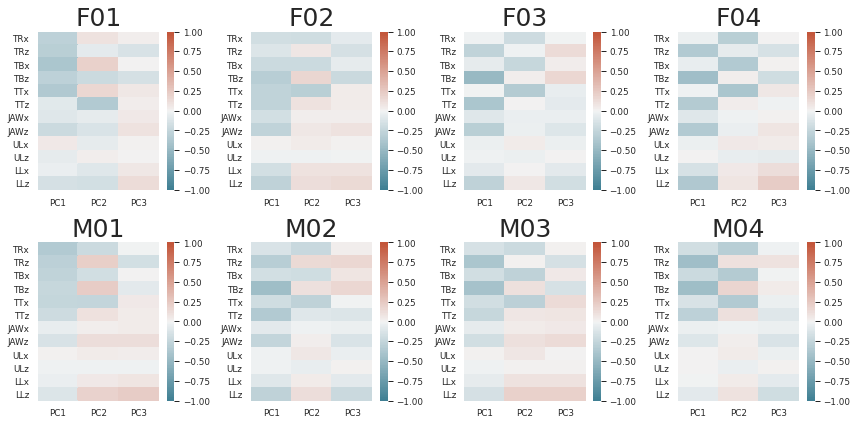

In [59]:
sns.set_theme(context='paper')
fig, arr = plt.subplots(2, 4, facecolor='white', figsize=(12, 6))
for spkr, ax in zip(spkr_list, arr.flatten()):
    loadings = pd.DataFrame(PC[spkr]['pca'].components_.T * np.sqrt(PC[spkr]['pca'].explained_variance_),
                            columns=pca_col,
                            index=artic_col)
    sns.heatmap(
        loadings,
        ax=ax,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        #square=True
    )
    ax.set_title(spkr, fontsize=25)
fig.tight_layout()

Check the PCA result by reconstructing to/from the reduced data

In [60]:
def _validate_pca_by_reconstruction(df, which_spkr, which_rate, which_vowel, which_time, artic_col, artic_col_norm, PC, Z):
    pca = PC[which_spkr]['pca']
    scaler = Scaler(which_spkr, Z)
    d = df.loc[(df.Speaker==which_spkr)&(df.Rate==which_rate)&(df.Vowel==which_vowel)&(df.TimeAt==which_time), artic_col]
    dn = df.loc[(df.Speaker==which_spkr)&(df.Rate==which_rate)&(df.Vowel==which_vowel)&(df.TimeAt==which_time), artic_col_norm]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5), facecolor='white')

    # Original data
    plot_palpha(ax1, pal_all[which_spkr], pha=None);
    plot_artic_df(ax1, d, 
                  tongue_x=['TRx','TBx','TTx'], 
                  tongue_y=['TRz','TBz','TTz'], 
                  jaw_x=['JAWx'], jaw_y=['JAWz'], 
                  lip_x=['ULx','LLx'], lip_y=['ULz','LLz'], 
                  tongue_spline=True, 
                  xlim=(-70,40), ylim=(-50,30), 
                  xtickspacing=20, ytickspacing=20,
                  xlabel='Horizontal (back<->front)', ylabel='Vertical (low<->high)',
                  sns_theme='whitegrid', sns_context='poster')
    ax1.set_title('Original', fontsize=25)

    # Normalized data
    plot_artic_df(ax2, dn, 
                  tongue_x=['TRx_norm','TBx_norm','TTx_norm'], 
                  tongue_y=['TRz_norm','TBz_norm','TTz_norm'], 
                  jaw_x=['JAWx_norm'], jaw_y=['JAWz_norm'], 
                  lip_x=['ULx_norm','LLx_norm'], lip_y=['ULz_norm','LLz_norm'], 
                  tongue_spline=True, 
                  xlim=(-2.5,2.5), ylim=(-2.5,2.5), # Change to normalized scale
                  xtickspacing=20, ytickspacing=20,
                  xlabel='Horizontal (back<->front)', ylabel='Vertical (low<->high)',
                  sns_theme='whitegrid', sns_context='poster')
    ax2.set_xlim([-2,2])
    ax2.set_ylim([-2,2])
    ax2.set_title('Normalized', fontsize=25)

    # Reconstructed data
    dz = dn.values
    dz = pca.transform(dz)
    dz = pca.inverse_transform(dz)
    dz = scaler.inverse_transform(dz, 'artic')
    dnz = dn.copy()
    dnz[artic_col] = dz
    plot_palpha(ax3, pal_all[which_spkr], pha=None);
    plot_artic_df(ax3, dnz, 
                  tongue_x=['TRx','TBx','TTx'], 
                  tongue_y=['TRz','TBz','TTz'], 
                  jaw_x=['JAWx'], jaw_y=['JAWz'], 
                  lip_x=['ULx','LLx'], lip_y=['ULz','LLz'], 
                  tongue_spline=True, 
                  xlim=(-70,40), ylim=(-50,30), 
                  xtickspacing=20, ytickspacing=20,
                  xlabel='Horizontal (back<->front)', ylabel='Vertical (low<->high)',
                  sns_theme='whitegrid', sns_context='poster')
    ax3.set_title('Reconstructed', fontsize=25);
    plt.suptitle(f'{which_spkr} (vowel={which_vowel}, rate={which_rate}, time={which_time})', fontsize=30, y=1.05);
    return fig, (ax1, ax2, ax3)

In [61]:
which_spkr = 'F01'
which_vowel = 'IY1'
which_rate = 'N'
which_time = 0.5

def func_rc(which_spkr, which_rate, which_vowel, which_time):
    with sns.plotting_context(context='paper', font_scale=0.8):
        fig, arr = _validate_pca_by_reconstruction(DF, which_spkr, which_rate, which_vowel, which_time, artic_col, artic_col_norm, PC, Z)
        
interact(func_rc, which_spkr=spkr_list, which_rate=rate_list, which_vowel=vowel_list, which_time=time_list)

interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

<function __main__.func_rc(which_spkr, which_rate, which_vowel, which_time)>

Compare articulatory mid-points at normal and fast rate

In [62]:
def _plot_artic_single(df, ax, which_spkr, which_rate, which_vowel, which_time, custom_vowels, 
                      tongue_idx, jaw_idx, lip_idx, vowel2ipa, font_scale=1, show_legend=True, 
                      marker='o', markerfacecolor=True, linestyle='--', tongue_spline=False, **kwargs):
    with sns.plotting_context('paper', font_scale=font_scale, rc=kwargs):
        sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
        ax = plot_palpha(ax, pal_all[which_spkr], pha=None, tickspacing=10)

        colors = sns.color_palette('tab10', len(custom_vowels))
        lines = []
        for which_vowel, color in zip(custom_vowels, colors):
            d = DF.loc[(DF.Speaker==which_spkr)&(DF.Rate==which_rate)&(DF.Vowel==which_vowel)&(DF.TimeAt==which_time), artic_col]
            d = d.median(axis=0).values
            TNG = d[tongue_idx]
            JAW = d[jaw_idx]
            LIP = d[lip_idx]

            # Draw tongue
            if markerfacecolor:
                ax.plot(TNG[0::2].T, TNG[1::2].T, ls='', marker=marker, ms=3, color=color, zorder=1)
            else:
                ax.plot(TNG[0::2].T, TNG[1::2].T, ls='', marker=marker, ms=3, markerfacecolor=markerfacecolor, color=color, zorder=1)
                
            if tongue_spline:
                f = interpolate.interp1d(TNG[0::2], TNG[1::2], kind='quadratic')
                xnew = np.linspace(TNG[0], TNG[-2], 10, endpoint=True)
                ynew = f(xnew)
                ax.plot(xnew, ynew, linestyle=linestyle, marker='', color=color, zorder=1)
            else:
                ax.plot(TNG[0::2], TNG[1::2], ls=linestyle, marker=marker, ms=3,  color=color, zorder=1)

            # Draw jaw and lips
            if markerfacecolor:
                ax.plot(LIP[0::2], LIP[1::2], ls='None', color=color, marker=marker, ms=3, zorder=1)
                ax.plot(JAW[0::2], JAW[1::2], ls='None', color=color, marker=marker, ms=3, zorder=1, label=vowel2ipa[which_vowel])
            elif markerfacecolor:
                ax.plot(LIP[0::2], LIP[1::2], ls='None', color=color, 
                        marker=marker, ms=3, markerfacecolor=markerfacecolor, zorder=1)
                ax.plot(JAW[0::2], JAW[1::2], ls='None', color=color, 
                        marker=marker, ms=3, markerfacecolor=markerfacecolor, zorder=1, label=vowel2ipa[which_vowel])
            ls, = ax.plot([],[],color=color,marker='o',ms=5)
            lines += [ls]
            
        if show_legend:
            ax.legend(lines, [vowel2ipa[v] for v in custom_vowels])
    return ax

Text(0.5, 1.0, 'Fast rate')

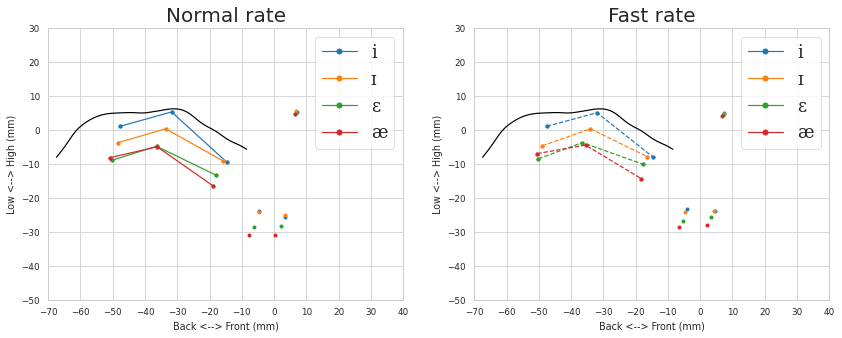

In [63]:
custom_vowels = ['IY1','IH1','EH1','AE1']

tongue_idx = [0, 1, 2, 3, 4, 5]
jaw_idx = [6, 7]
lip_idx = [8, 9, 10, 11]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), facecolor='white')
# --- Normal rate
_plot_artic_single(DF, ax1, which_spkr, 'N', which_vowel, which_time, custom_vowels,
                   tongue_idx, jaw_idx, lip_idx, vowel2ipa, font_scale=2, show_legend=True,
                   linestyle='-', marker='o',
                   tongue_spline=False)
ax1.set_title('Normal rate', fontsize=20)

# --- Fast rate
_plot_artic_single(DF, ax2, which_spkr, 'F', which_vowel, which_time, custom_vowels,
                   tongue_idx, jaw_idx, lip_idx, vowel2ipa, font_scale=2, show_legend=True,
                   linestyle='--', marker='o', markerfacecolor='None',
                   tongue_spline=False)
ax2.set_title('Fast rate', fontsize=20)

Text(0.5, 1.0, 'Fast rate')

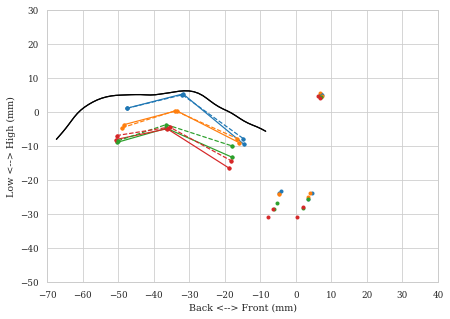

In [64]:
fig, ax = plt.subplots(1, figsize=(7, 5), facecolor='white')
# --- Normal rate
_plot_artic_single(DF, ax, which_spkr, 'N', which_vowel, which_time, custom_vowels,
                   tongue_idx, jaw_idx, lip_idx, vowel2ipa, font_scale=5, show_legend=False,
                   linestyle='-', marker='o',
                   tongue_spline=False)
ax1.set_title('Normal rate', fontsize=20)

# --- Fast rate
_plot_artic_single(DF, ax, which_spkr, 'F', which_vowel, which_time, custom_vowels,
                   tongue_idx, jaw_idx, lip_idx, vowel2ipa, font_scale=5, show_legend=False,
                   linestyle='--', marker='o', markerfacecolor='None',
                   tongue_spline=False)
ax2.set_title('Fast rate', fontsize=20)

### Checking articulation-acoustics relations

In [65]:
def _get_acous_artic_center(df, which_spkr, which_rate, which_vowel, which_time, 
                            acous_col, artic_col, stat='median', show_real=True):
    '''Get the center slice both from artic and acous data
    based on acoustic near-median point
    '''
    d = df.loc[(df.Speaker==which_spkr)&(df.Rate==which_rate)&(df.Vowel==which_vowel)&(df.TimeAt==which_time)]
    acous = d[acous_col].values
    artic = d[artic_col].values
    
    acous_m = d[acous_col].median(axis=0).values.squeeze()
    artic_m = d[artic_col].median(axis=0).values.squeeze()
    idx = np.sum((acous - acous_m)**2, axis=1).argmax()
    if show_real:
        return acous[idx,:], artic[idx,:]
    else:
        return acous_m, artic_m

In [66]:
def _plot_artic_acous_center_by_rate(ax1, ax2, df, which_spkr, which_vowel, which_time,
                                     acous_col, artic_col,
                                     colors=['b','r'],
                                     tongue_idx=[0, 1, 2, 3, 4, 5], 
                                     jaw_idx=[6, 7], lip_idx=[8, 9, 10, 11]):
    '''Plot artic, acous centers for a given vowel'''
    artic_ms = 5
    xlim=(-70,40)
    ylim=(-50,30)
    
    sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
    ax1 = plot_palpha(ax1, pal_all[which_spkr], pha=None)
    
    for which_rate, color in zip(['N','F'], colors):
        acous, artic = _get_acous_artic_center(DF, which_spkr, which_rate, which_vowel, which_time,
                                               acous_col, artic_col, 
                                               stat='median', show_real=False)

        # --- Artic plot
        TNG = artic[tongue_idx]
        JAW = artic[jaw_idx]
        LIP = artic[lip_idx]

        ax1.plot(TNG[0::2].T, TNG[1::2].T, color=color, ls='--', marker='o', ms=artic_ms)
        ax1.plot(LIP[0::2], LIP[1::2], ls='None', color=color, marker='o', ms=artic_ms, zorder=1)
        ax1.plot(JAW[0::2], JAW[1::2], ls='None', color=color, marker='o', ms=artic_ms, zorder=1)

        # Prettify
        ax1.xaxis.set_major_locator(plticker.MultipleLocator(base=20))
        ax1.yaxis.set_major_locator(plticker.MultipleLocator(base=20))

        # --- Acous plot
        F1, F2 = acous[0], acous[1]
        ax2 = plot_F1F2(ax2, F1, F2, show_label=False, use_mel=True, show_title=False, color=color)
        
    return ax1, ax2

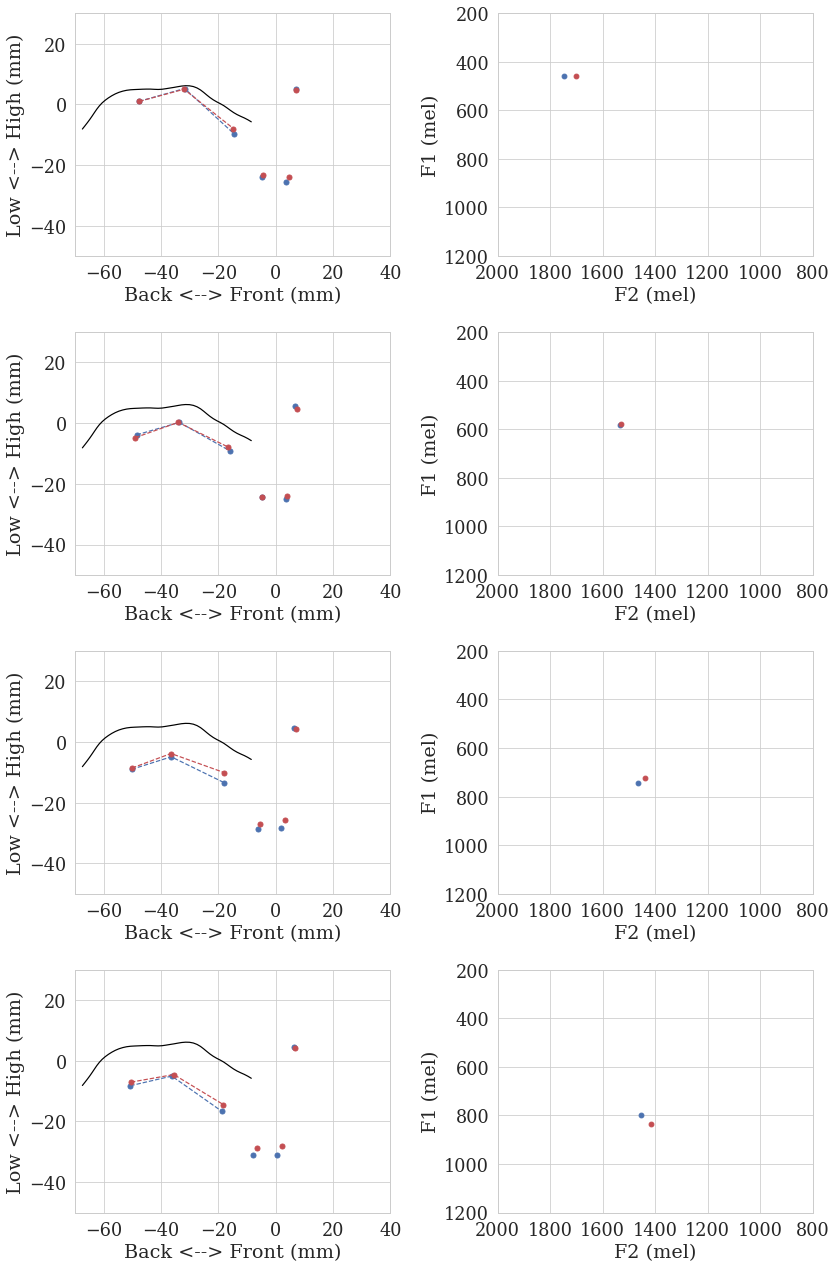

In [67]:
which_spkr = 'F01'
which_time = 0.5
custom_vowels = ['IY1','IH1','EH1','AE1']

with sns.plotting_context('paper', font_scale=2):
    fig, arr = plt.subplots(4, 2, facecolor='white', figsize=(12,18))
    for i, which_vowel in enumerate(custom_vowels):
        _plot_artic_acous_center_by_rate(arr[i,0], arr[i,1], DF, which_spkr, which_vowel, which_time, acous_col, artic_col)
    fig.tight_layout()

In [62]:
# which_spkr = 'F01'
# which_time = 0.5
# which_vowel = 'IY1'

# with sns.plotting_context('paper', font_scale=2):
#     fig, arr = plt.subplots(1, 2, facecolor='white', figsize=(12,5))
#     _plot_artic_acous_center_by_rate(arr[0], arr[1], DF, which_spkr, which_vowel, which_time, acous_col, artic_col);
#     fig.tight_layout()

<h3 style="background-color: blue">Adding consonant context labels</h3>

In [68]:
# Define Phone Labels
from io import StringIO

lab = StringIO('''Phone,Label,Tag,Interest,PoA
AA,vowel,V,T,tongue
AE,vowel,V,T,tongue
AH,vowel,V,T,tongue
AO,vowel,VV,F,tongue
AW,vowel,VV,T,tongue
AY,vowel,VV,T,tongue
B,stop,C,T,bilabial
CH,affricate,C,F,palatoalveolar
D,stop,C,T,alveolar
DH,fricative,C,T,interdental
EH,vowel,V,T,tongue
ER,vowel,V,F,tongue
EY,vowel,VV,T,tongue
F,fricative,C,T,labiodental
G,stop,C,T,velar
HH,aspirate,C,T,pharyngeal
IH,vowel,V,T,tongue
IY,vowel,V,T,tongue
JH,affricate,C,F,palatoalveolar
K,stop,C,T,velar
L,liquid,C,F,lateral
M,nasal,C,F,bilabial
N,nasal,C,F,alveolar
NG,nasal,C,F,velar
OW,vowel,VV,T,tongue
OY,vowel,VV,T,tongue
P,stop,C,T,bilabial
R,liquid,C,F,alveolar
S,fricative,C,T,alveolar
SH,fricative,C,T,palatoalveolar
T,stop,C,T,alveolar
TH,fricative,C,T,interdental
UH,vowel,V,T,tongue
UW,vowel,V,T,tongue
V,fricative,C,T,labiodental
W,semivowel,C,F,labiovelar
Y,semivowel,C,F,velar
Z,fricative,C,T,alveolar
ZH,fricative,C,T,palatoalveolar
sp,sp,sp,T,sp
BEG,sp,sp,T,sp
END,sp,sp,T,sp
''')
LAB = pd.read_csv(lab,sep=',')
LAB.head()

,Phone,Label,Tag,Interest,PoA
0,AA,vowel,V,T,tongue
1,AE,vowel,V,T,tongue
2,AH,vowel,V,T,tongue
3,AO,vowel,VV,F,tongue
4,AW,vowel,VV,T,tongue


In [69]:
# Read words
words = [w.lower() for w in DF.Word.unique().tolist()]
print('Number of words:', len(words))

Number of words: 1056


In [70]:
import cmudict

Pronunciation = []
Tag = []
# Interest = []
PlaceOfArticulation = []
cmu_words = cmudict.words()
cmu_dict = cmudict.dict()

error = []
for word in tqdm(words, total=len(words)):
    prono_candidates = cmu_dict[word]
    prono_candidates = prono_candidates[0] # only consider the first option for now

    # Add pronunciation
    Pronunciation += ['-'.join(prono_candidates)]
    # Add tag
    #Tag += ['-'.join([LAB.Tag[LAB.Phone==re.sub('(\w+)[0-9]', '\\1', p)].values[0] for p in prono_candidates])]
    Tag += ['-'.join([LAB.Tag[LAB.Phone==re.sub('(\w+)[0-9]', '\\1', p)].values[0] + f"{re.search('[0-9]', p)[0] if re.search('[0-9]', p) else ''}" 
                      for p in prono_candidates])]
    # Add interest
    #Interest += ['-'.join([LAB.Interest[LAB.Phone==re.sub('(\w+)[0-9]', '\\1', p)].values[0] for p in prono_candidates])]
    # Add PoA
    PlaceOfArticulation +=['-'.join([LAB.PoA[LAB.Phone==re.sub('(\w+)[0-9]', '\\1', p)].values[0] for p in prono_candidates])]

WDICT = pd.DataFrame({
    'Word': words,
    'Pronunciation': Pronunciation,
    'Tag': Tag,
    #'Interest': Interest,
    'PlaceOfArticulation': PlaceOfArticulation
})

if save_again:
    WDICT.to_csv(os.path.join(save_dir, 'context.csv'), index=False)
    print('Saved')
else:
    print('Skipping saving')

WDICT.head()

100%|██████████| 1056/1056 [00:01<00:00, 862.33it/s]

Saved


,Word,Pronunciation,Tag,PlaceOfArticulation
0,canoe,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
1,smooth,S-M-UW1-DH,C-C-V1-C,alveolar-bilabial-tongue-interdental
2,slid,S-L-IH1-D,C-C-V1-C,alveolar-lateral-tongue-alveolar
3,on,AA1-N,V1-C,tongue-alveolar
4,planks,P-L-AE1-NG-K-S,C-C-V1-C-C-C,bilabial-lateral-tongue-velar-velar-alveolar


Add PoA columns for pre and post vowel Cs

In [71]:
col = ['PreVowelPOA', 'PostVowelPOA']
DF[col] = ''
# For PreVowel
for which_phone in tqdm(DF.PreVowel.unique(), total=len(DF.PreVowel.unique())):
    which_phone = re.sub('[0-9]','',which_phone)
    DF.loc[DF.PreVowel==which_phone, 'PreVowelPOA'] = LAB.PoA[LAB.Phone==which_phone].values[0]
    
# For PostVowel
for which_phone in tqdm(DF.PostVowel.unique(), total=len(DF.PostVowel.unique())):
    which_phone = re.sub('[0-9]','',which_phone)
    DF.loc[DF.PostVowel==which_phone, 'PostVowelPOA'] = LAB.PoA[LAB.Phone==which_phone].values[0]


100%|██████████| 1/1 [00:00<00:00, 155.14it/s]


In [72]:
DF.tail(3)

,Token,FileID,Speaker,Block,Rate,Sent,Rep,Word,PreVowel,Vowel,...,TTx_norm,TTz_norm,JAWx_norm,JAWz_norm,ULx_norm,ULz_norm,LLx_norm,LLz_norm,PreVowelPOA,PostVowelPOA
140302,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.251051,-0.403396,-0.127857,-0.062283,0.127111,0.047193,0.040988,-0.027688,velar,sp
140303,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.224260,-0.379937,-0.122679,-0.035660,0.105324,-0.037390,0.069666,0.076274,velar,sp
140304,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.173027,-0.308262,-0.098349,0.032341,0.138669,-0.149052,0.134113,0.268623,velar,sp


Add Pronunciation, Tag, PoA to data

In [73]:
col = ['Pronunciation','Tag','PlaceOfArticulation']
DF[col] = ''

for which_word in tqdm(DF.Word.unique(), total=len(DF.Word.unique())):
    DF.loc[DF.Word==which_word, col] = WDICT.loc[WDICT.Word==which_word.lower(), col].values[0].tolist()

100%|██████████| 1056/1056 [00:07<00:00, 134.15it/s]


In [74]:
DF.reset_index(drop=True, inplace=True)
print(DF.shape)
DF[col]

(140305, 59)


,Pronunciation,Tag,PlaceOfArticulation
0,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
1,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
2,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
3,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
4,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
...,...,...,...
140300,K-AH1-M,C-V1-C,velar-tongue-bilabial
140301,K-AH1-M,C-V1-C,velar-tongue-bilabial
140302,K-AH1-M,C-V1-C,velar-tongue-bilabial
140303,K-AH1-M,C-V1-C,velar-tongue-bilabial


---
<h2 style="background-color: yellow;color:black">2. Sanity checks</h2>

- Compare AcousVar and ArticVar (static, dynamic)

In [75]:
var_ylim = [0, 1]

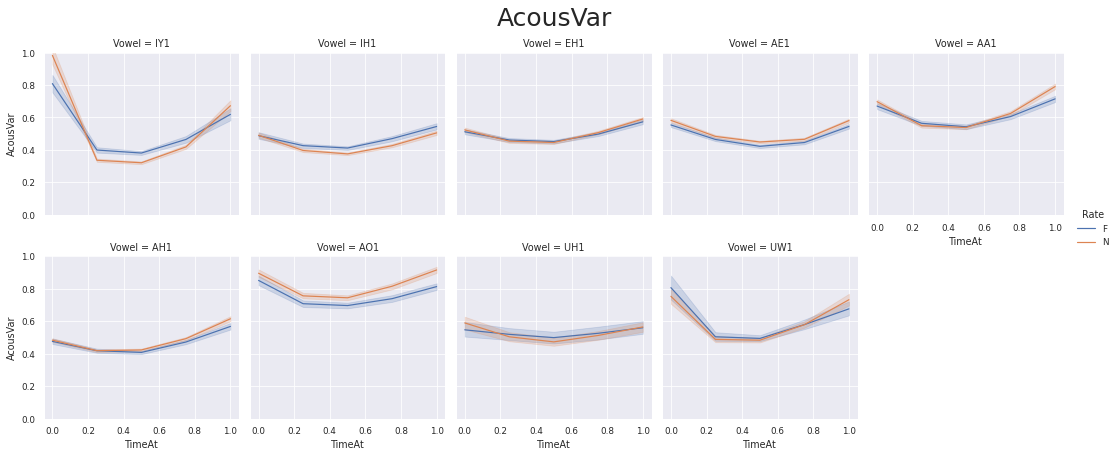

In [76]:
# AcousVar
sns.set_theme(context='paper')
g = sns.FacetGrid(data=DF.loc[(DF.Vowel.isin(vowel_list))], 
                  col='Vowel', col_wrap=num_points, col_order=vowel_list,
                  height=3, hue='Rate')
g.map(sns.lineplot, 'TimeAt', 'AcousVar')
plt.gca().set_ylim(var_ylim);
plt.gcf().set_facecolor('white')
plt.suptitle('AcousVar', fontsize=25, y=1.05)
g.add_legend();

For a single speaker

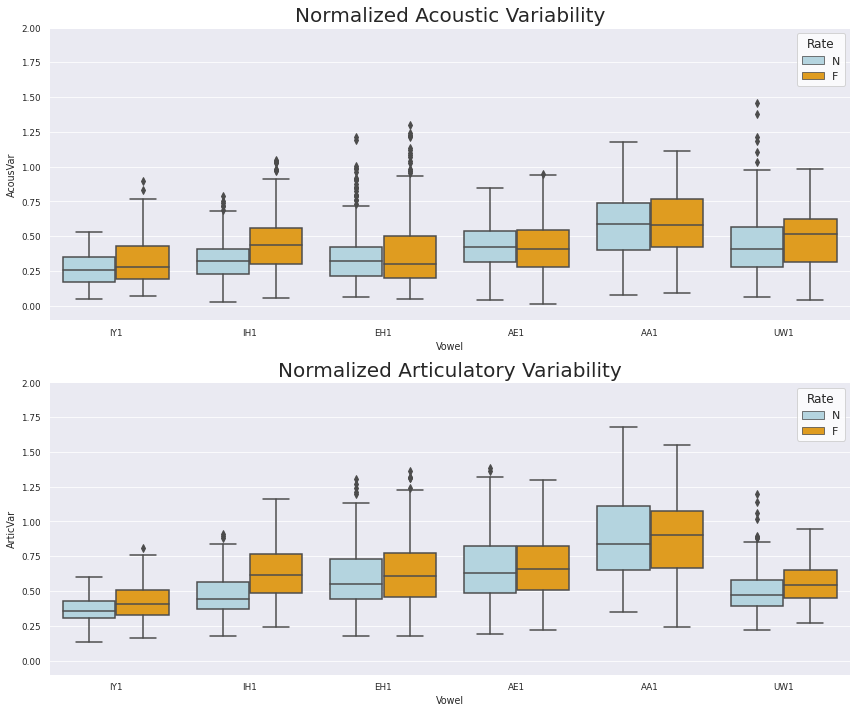

In [77]:
ylim = [-0.1, 2]
custom_vowels = ['IY1','IH1','EH1','AE1','AA1','UW1']

which_spkr = 'F01'
which_time = 0.5

fig, (ax1, ax2) = plt.subplots(2, 1, facecolor='white', figsize=(12,10), sharey=True)
with sns.plotting_context(context='paper', font_scale=1.5):
    sns.set_theme(style='whitegrid')
    
    # AcousVar
    sns.boxplot(data=DF.loc[(DF.Vowel.isin(custom_vowels))&(DF.TimeAt==which_time)&(DF.Speaker==which_spkr)], 
                ax=ax1, x='Vowel', y='AcousVar', order=custom_vowels, 
                hue='Rate', hue_order=['N','F'], palette=['lightblue', 'orange'])
    ax1.set_title('Normalized Acoustic Variability', fontsize=20)
    ax1.set_ylim(ylim)

    # ArticVar
    sns.boxplot(data=DF.loc[(DF.Vowel.isin(custom_vowels))&(DF.TimeAt==which_time)&(DF.Speaker==which_spkr)], 
                ax=ax2, x='Vowel', y='ArticVar', order=custom_vowels, 
                hue='Rate', hue_order=['N','F'], palette=['lightblue', 'orange'])
    ax2.set_title('Normalized Articulatory Variability', fontsize=20)
    ax2.set_ylim(ylim)

fig.tight_layout()

For all speaker

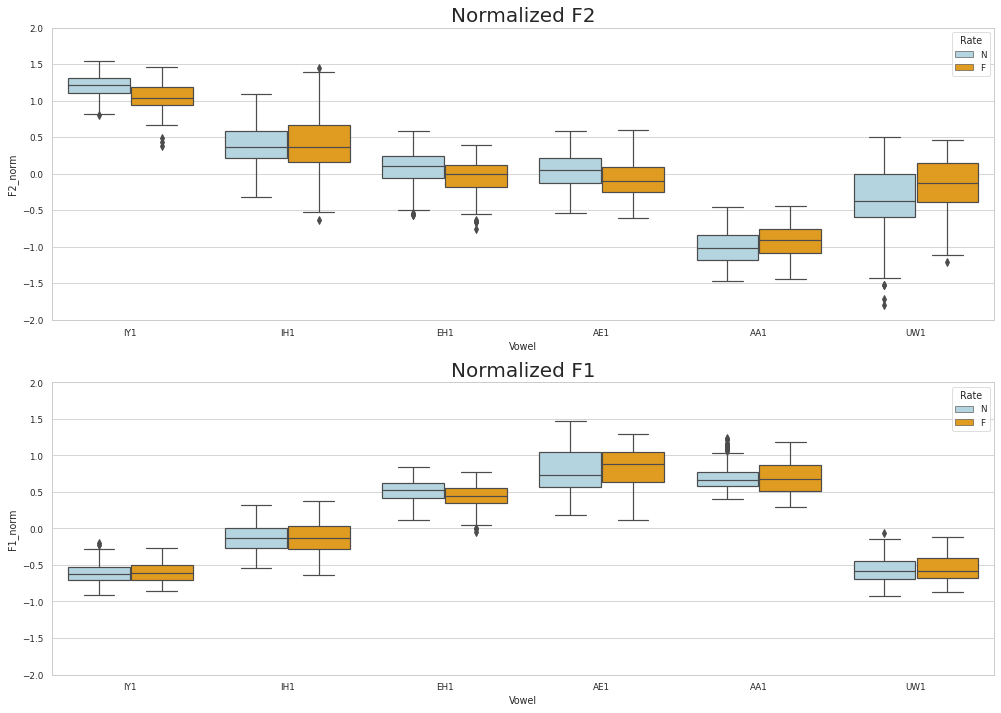

In [78]:
fig, (ax1, ax2) = plt.subplots(2, 1, facecolor='white', figsize=(14,10))

sns.boxplot(data=DF.loc[(DF.Vowel.isin(custom_vowels))&(DF.TimeAt==which_time)&(DF.Speaker==which_spkr)], 
            ax=ax1, x='Vowel', y='F2_norm', order=custom_vowels, 
            hue='Rate', hue_order=['N','F'], palette=['lightblue', 'orange'])
ax1.set_title('Normalized F2', fontsize=20)
ax1.set_ylim([-2,2])

sns.boxplot(data=DF.loc[(DF.Vowel.isin(custom_vowels))&(DF.TimeAt==which_time)&(DF.Speaker==which_spkr)], 
            ax=ax2, x='Vowel', y='F1_norm', order=custom_vowels, 
            hue='Rate', hue_order=['N','F'], palette=['lightblue', 'orange'])
ax2.set_title('Normalized F1', fontsize=20)
ax2.set_ylim([-2,2])

fig.tight_layout()

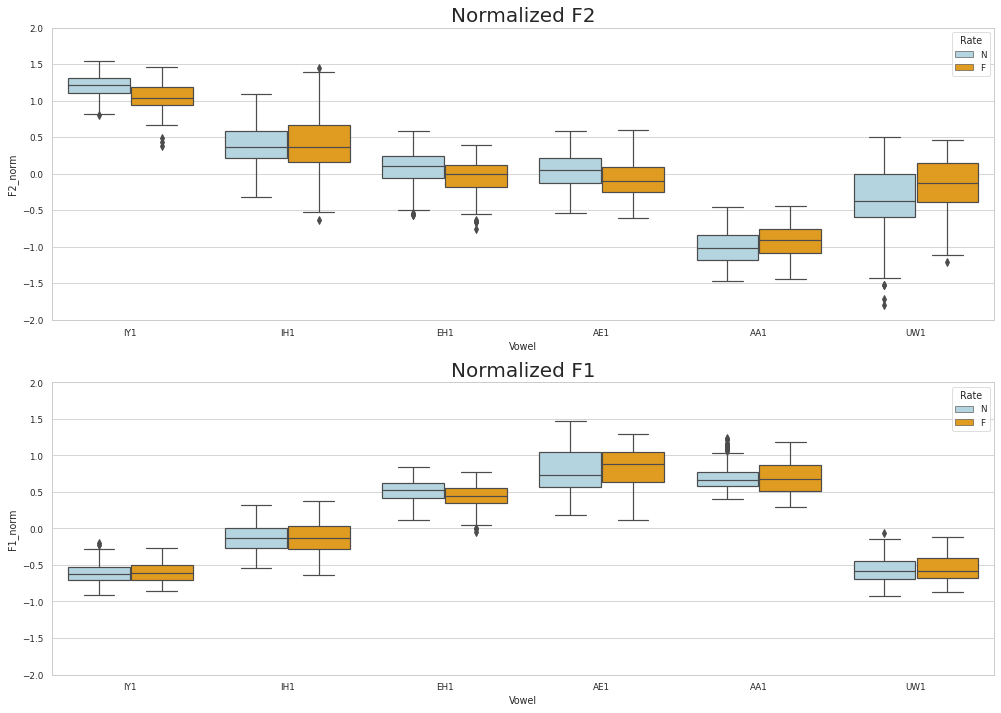

In [79]:
fig, (ax1, ax2) = plt.subplots(2, 1, facecolor='white', figsize=(14,10))

sns.boxplot(data=DF.loc[(DF.Vowel.isin(custom_vowels))&(DF.TimeAt==which_time)&(DF.Speaker==which_spkr)], 
            ax=ax1, x='Vowel', y='F2_norm', order=custom_vowels, 
            hue='Rate', hue_order=['N','F'], palette=['lightblue', 'orange'])
ax1.set_title('Normalized F2', fontsize=20)
ax1.set_ylim([-2,2])

sns.boxplot(data=DF.loc[(DF.Vowel.isin(custom_vowels))&(DF.TimeAt==which_time)&(DF.Speaker==which_spkr)], 
            ax=ax2, x='Vowel', y='F1_norm', order=custom_vowels, 
            hue='Rate', hue_order=['N','F'], palette=['lightblue', 'orange'])
ax2.set_title('Normalized F1', fontsize=20)
ax2.set_ylim([-2,2])

fig.tight_layout()

In [80]:
DF.columns

Index(['Token', 'FileID', 'Speaker', 'Block', 'Rate', 'Sent', 'Rep', 'Word',
       'PreVowel', 'Vowel', 'PostVowel', 'Duration', 'TimeAt', 'TimeSec', 'F1',
       'F2', 'F3', 'TRx', 'TRz', 'TBx', 'TBz', 'TTx', 'TTz', 'JAWx', 'JAWz',
       'ULx', 'ULz', 'LLx', 'LLz', 'F1_mel', 'F2_mel', 'F3_mel', 'AcousVar',
       'ArticVar', 'RescaleFactorAcous', 'RescaleFactorArtic', 'F1_grandmean',
       'F2_grandmean', 'F3_grandmean', 'F1_norm', 'F2_norm', 'F3_norm',
       'TRx_norm', 'TRz_norm', 'TBx_norm', 'TBz_norm', 'TTx_norm', 'TTz_norm',
       'JAWx_norm', 'JAWz_norm', 'ULx_norm', 'ULz_norm', 'LLx_norm',
       'LLz_norm', 'PreVowelPOA', 'PostVowelPOA', 'Pronunciation', 'Tag',
       'PlaceOfArticulation'],
      dtype='object')

---
## 3. Save the result

In [81]:
csv_file = os.path.join(save_dir, 'data_2021-04-27.csv')
DF.to_csv(csv_file, index=False)
print(csv_file, 'saved')

data_processed/data_2021-04-27.csv saved


# END OF THE NOTEBOOK